In [ ]:
# Install yfinance package
try:
    print("Loading 'yfinance' library...")
    !pip install yfinance --quiet
except (Exception, ImportError, Error) as error:
    print("An error occurred while trying to load the 'yfinance' library. The specific error information is: \n",error)
finally:
    print("yfinance has been successfully loaded!")

Loading 'yfinance' library...
yfinance has been successfully loaded!


In [ ]:
# import packages required for analysis
try:
    print("Importing packages...")
    import numpy as np # mathematical functions
    import pandas as pd # data processing
    import yfinance as yf # To pull historical data from Yahoo Finance
    import matplotlib as mpl
    import matplotlib.pyplot as plt # For plotting data and to allow for plots to display in notebook (inline)
    %matplotlib inline
    mpl.style.use(['ggplot'])
    from IPython.display import display # display multiple tables in notebook output
    from scipy import stats  #Statistical package
    import seaborn as sns # regression plots
    from sklearn.linear_model import LinearRegression # Perform linear regression
except ImportError as error:
    print("An error occurred while trying to import the required packages. The specific error information is: \n",error)
finally:
    print("Modules have been successfully loaded!")

Importing packages...
Modules have been successfully loaded!


In [ ]:
#Pull Ticker file with S&P 500 information
tckr = yf.Ticker("^GSPC")

#Pull historical data for S&P 500 and stored in dataframe
data = tckr.history(period="max")

#Reset index for later processing also allows for dataframe to be queried by date
data.reset_index(inplace=True)

print("The historical data for symbol {0} was obtained. This symbol is traded on exchange {1}."
      .format(tckr.info["shortName"],tckr.info["exchange"]))

The historical data for symbol S&P 500 was obtained. This symbol is traded on exchange SNP.


In [ ]:
#Indicate the first and last date of data to ensure it captures the correct time length
print("The first date of {0} data is: \t {1} \nThe last date of {0} data is: \t {2}"
     .format(tckr.info["shortName"],data.loc[0,"Date"].date(),data.at[len(data)-1,"Date"].date()))

The first date of S&P 500 data is: 	 1927-12-30 
The last date of S&P 500 data is: 	 2024-01-09


In [ ]:
#Provide summary statistics for data
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,24121.000000,24121.000000,24121.000000,24121.000000,2.412100e+04,24121.0,24121.0
mean,589.515360,613.056332,605.613808,609.571023,8.885339e+08,0.0,0.0
std,987.115466,981.478143,970.053106,976.126922,1.605321e+09,0.0,0.0
min,0.000000,4.400000,4.400000,4.400000,0.000000e+00,0.0,0.0
25%,9.620000,24.559999,24.559999,24.559999,1.490000e+06,0.0,0.0
50%,41.740002,102.540001,101.010002,101.820000,1.975000e+07,0.0,0.0
75%,994.000000,1003.429993,984.150024,994.349976,8.997000e+08,0.0,0.0
max,4804.509766,4818.620117,4780.979980,4796.560059,1.145623e+10,0.0,0.0


In [ ]:
#Write raw data to csv file
try:
    print("Saving raw dataframe to csv file...")
    data.to_csv("./{0}_day_data_raw.csv".format(tckr.info["exchange"]))
except:
    print("And error occurred while trying to save data to csv file")
finally:
    print("Raw dataset has been successfully saved to csv file")

Saving raw dataframe to csv file...
Raw dataset has been successfully saved to csv file


In [ ]:
#Percent change
def p_chg(x1,x2):
    """
    This function will calculate the percent change between two values x1 and x2.
    x1 - Initial value
    x2 - Final value
    The output will be rounded to two decimal places
    """

    y = ((x2-x1)/x1)*100
    return y

#create function to highlight columns in table
def highlight_cols(s,color):
    return 'background-color: %s' % color

In [ ]:
#Remove unnecessary columns Dividends and Stock Split
data.drop(columns=['Dividends','Stock Splits'],inplace=True)

In [ ]:
#There is "open" value data missing from dataframe, need to find out where data is missing
print("There are {0:,} rows with a zero value for the 'Open' column."
      .format(data[data['Open'] == 0].value_counts().count()))

There are 5,075 rows with a zero value for the 'Open' column.


In [ ]:
print("The last row with an 'Open' value of zero was {0}.".format(data[data['Open'] == 0].tail(1).iloc[0]['Date'].date()))

The last row with an 'Open' value of zero was 1982-04-19.


In [ ]:
#Iterate through each row of 'Open' column of dataframe, if Open == 0 then grab close from previous day and add to Open column
#(assume no extended hr trading)
index = 0
for value in data['Open']:
    if value == 0:
        data.loc[index,'Open'] = data.loc[index-1,'Close']
    index +=1

In [ ]:
#Check to make sure all Open rows have value
print("There are {0} rows with a zero value for the 'Open' column.".format(data[data['Open'] == 0].value_counts().count()))

There are 0 rows with a zero value for the 'Open' column.


In [ ]:
#Add new columns for year, Month, Week, and Weekday
data = data.assign(Year = data['Date'].dt.year, M_num = data['Date'].dt.month, M_nm = data['Date'].dt.month_name(),
                  D_num = data['Date'].dt.weekday, D_nm = data['Date'].dt.day_name(), Wk = data['Date'].dt.isocalendar().week)

In [ ]:
#Add new columns for percent change in intraday high/low and open/close
data = data.assign(P_intra = p_chg(data['Low'],data['High']),P_day = p_chg(data['Open'],data['Close']))

In [ ]:
#There are daily percent changes that are 0, check to see how many
print("There are {0:,} rows (or {1:.2%} of total) where the daily percent change is zero. The last entry where the daily price change was zero was {2}."
      .format(data[data['P_day'] == 0].value_counts().count(),
              data[data['P_day'] == 0].value_counts().count()/data.value_counts().count(),
              data[data['P_day'] == 0]['Date'].tail(1).iloc[0].date()))

There are 8,580 rows (or 35.57% of total) where the daily percent change is zero. The last entry where the daily price change was zero was 2017-04-10.


In [ ]:
#There are intraday percent changes that are 0, unsure if this is correct or data error
print("There are {0:,} rows where the intraday change is zero. The last entry where the intraday price change was zero was {1}."
      .format(data[data['P_intra'] == 0].value_counts().count(), data[data['P_intra'] == 0]['Date'].tail(1).iloc[0].date()))

There are 8,547 rows where the intraday change is zero. The last entry where the intraday price change was zero was 1983-06-30.


In [ ]:
for index in range(0,len(data['Volume'])-1):
    data.loc[index+1,'P_Vol'] = p_chg(data.loc[index,'Volume'],data.loc[index+1,'Volume'])

<ipython-input-7-7f5ee41924b9>:10: RuntimeWarning: invalid value encountered in long_scalars
  y = ((x2-x1)/x1)*100
<ipython-input-7-7f5ee41924b9>:10: RuntimeWarning: invalid value encountered in long_scalars
  y = ((x2-x1)/x1)*100
<ipython-input-7-7f5ee41924b9>:10: RuntimeWarning: divide by zero encountered in long_scalars
  y = ((x2-x1)/x1)*100


In [ ]:
#Iterate through dataframe, checking for changes in previous closing vs opening and calculating difference (if applicable)
for index in range(0,len(data)-1):
    if data.loc[index+1,'Open'] != data.loc[index,'Close']:
        data.loc[index+1,'Ex_trd'] = data.loc[index+1,'Open'] - data.loc[index,'Close']
        data.loc[index+1,'PEx_trd'] = p_chg(data.loc[index,'Close'],data.loc[index+1,'Open'])

In [ ]:
print("There are {0:,} rows in this dataframe and there are {1:,} rows where the previous close price \
differed from the next day's opening price. That's approximately {2:.3f}% of the total trading days."
      .format(len(data),data["Ex_trd"].count(),data["Ex_trd"].count()/len(data)*100))

There are 24,121 rows in this dataframe and there are 13,974 rows where the previous close price differed from the next day's opening price. That's approximately 57.933% of the total trading days.


In [ ]:
#Write clean, processed data to csv file
try:
    print("Saving cleaned dataframe to csv file...")
    data.to_csv("./{0}_day_data_clean.csv".format(tckr.info["exchange"]))
except:
    print("And error occurred while trying to save data to csv file")
finally:
    print("Cleaned dataset has been successfully saved to csv file")

Saving cleaned dataframe to csv file...
Cleaned dataset has been successfully saved to csv file


In [ ]:
data.tail(10)


,Date,Open,High,Low,Close,Volume,Year,M_num,M_nm,D_num,D_nm,Wk,P_intra,P_day,P_Vol,Ex_trd,PEx_trd
24111,2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,2023,12,December,1,Tuesday,52,0.552071,0.333906,-17.489341,4.229980,0.088966
24112,2023-12-27 00:00:00-05:00,4773.450195,4785.390137,4768.899902,4781.580078,2748450000,2023,12,December,2,Wednesday,52,0.345787,0.170315,9.329690,-1.299805,-0.027222
24113,2023-12-28 00:00:00-05:00,4786.439941,4793.299805,4780.979980,4783.350098,2698860000,2023,12,December,3,Thursday,52,0.257684,-0.064554,-1.804290,4.859863,0.101637
24114,2023-12-29 00:00:00-05:00,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,2023,12,December,4,Friday,52,0.766835,-0.272844,15.828906,-0.470215,-0.009830
24115,2024-01-02 00:00:00-05:00,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,2024,1,January,1,Tuesday,1,0.670387,-0.049948,19.736985,-24.629883,-0.516368
24116,2024-01-03 00:00:00-05:00,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,2024,1,January,2,Wednesday,1,0.629402,-0.428772,5.549218,-17.760254,-0.374465
24117,2024-01-04 00:00:00-05:00,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,2024,1,January,3,Thursday,1,0.837328,-0.186054,-5.955310,-7.390137,-0.157076
24118,2024-01-05 00:00:00-05:00,4690.569824,4721.490234,4682.109863,4697.240234,3844370000,2024,1,January,4,Friday,1,0.841082,0.142209,3.469000,1.889648,0.040302
24119,2024-01-08 00:00:00-05:00,4703.700195,4764.540039,4699.819824,4763.540039,3742320000,2024,1,January,0,Monday,2,1.377079,1.272187,-2.654531,6.459961,0.137527
24120,2024-01-09 00:00:00-05:00,4741.930176,4765.470215,4730.350098,4756.500000,2236452000,2024,1,January,1,Tuesday,2,0.742442,0.307255,-40.238889,-21.609863,-0.453651


In [ ]:
#Create new dataframe to store Year and Close values
df = data[['Year','Close']]

#Extract maximum and minimum values from each year, also capture yearly open and close values
yr_max = df.groupby(by = ['Year']).max().rename(columns={'Close': 'Max_close'})
yr_min = df.groupby(['Year']).min().rename(columns={'Close': 'Min_close'})
yr_avg = df.groupby(['Year']).mean().rename(columns={'Close': 'Avg_close'})
yr_med = df.groupby(['Year']).median().rename(columns={'Close': 'Med_close'})
yr_start = df.groupby(['Year']).head(1).rename(columns={'Close': 'Yr_open'})
yr_end = df.groupby(['Year']).tail(1).rename(columns={'Close': 'Yr_end'})

#Merge the data along with year into new a dataframe
yr_df = pd.merge(yr_max,yr_min,how = 'left', on = 'Year')
yr_df = yr_df.merge(yr_avg,how = 'left', on = 'Year')
yr_df = yr_df.merge(yr_med,how = 'left', on = 'Year')
yr_df = yr_df.merge(yr_start,how = 'left', on = 'Year')
yr_df = yr_df.merge(yr_end,how = 'left', on = 'Year')

for index in range(0,len(yr_df)-1):
    yr_df.loc[index+1,'P_yr'] = p_chg(yr_df.loc[index,'Yr_end'],yr_df.loc[index+1,'Yr_end'])

In [ ]:
for year in yr_df['Year']: #Iterate through each year in yr_df dataframe
    i = int(yr_df[yr_df["Year"] == year].index.values) #pull index value for yr_df
    for index in range(0,len(data)-1):  #Iterate through each row in data dataframe
        if int(data.loc[index,'Year']) == int(year): # If 'year' from yr_df equal 'year' from data df look for matching value
            if float(data.loc[index,'Close']) == float(yr_df.loc[i,'Max_close']): #Looking for matching 'Max' value
                yr_df.loc[i,"Max_date"] = data.loc[index,"Date"]
            elif float(data.loc[index,'Close']) == float(yr_df.loc[i,'Min_close']): #Looking for matching 'Min' value
                yr_df.loc[i,"Min_date"] = data.loc[index,"Date"]
        else:
            continue

In [ ]:
try:
    print("Saving yearly dataframe to csv file...")
    yr_df.to_csv("./{0}_yr_data.csv".format(tckr.info["exchange"]))
except:
    print("And error occurred while trying to save data to csv file")
finally:
    print("Yearly data has been successfully saved to csv file")

Saving yearly dataframe to csv file...
Yearly data has been successfully saved to csv file


In [ ]:
yr_df.tail(10)


,Year,Max_close,Min_close,Avg_close,Med_close,Yr_open,Yr_end,P_yr,Max_date,Min_date
88,2015,2130.820068,1867.609985,2061.067741,2079.395020,2058.199951,2043.939941,-0.726600,2015-05-21 00:00:00-04:00,2015-08-25 00:00:00-04:00
89,2016,2271.719971,1829.079956,2094.651264,2104.104980,2012.660034,2238.830078,9.535023,2016-12-13 00:00:00-05:00,2016-02-11 00:00:00-05:00
90,2017,2690.159912,2257.830078,2449.076379,2436.100098,2257.830078,2673.610107,19.419966,2017-12-18 00:00:00-05:00,2017-01-03 00:00:00-05:00
91,2018,2930.750000,2351.100098,2746.214183,2743.149902,2695.810059,2506.850098,-6.237260,2018-09-20 00:00:00-04:00,2018-12-24 00:00:00-05:00
92,2019,3240.020020,2447.889893,2913.356380,2919.024902,2510.030029,3230.780029,28.878070,2019-12-27 00:00:00-05:00,2019-01-03 00:00:00-05:00
93,2020,3756.070068,2237.399902,3217.855849,3276.020020,3257.850098,3756.070068,16.258923,2020-12-31 00:00:00-05:00,2020-03-23 00:00:00-04:00
94,2021,4793.060059,3700.649902,4273.385635,4304.000000,3700.649902,4766.180176,26.892739,2021-12-29 00:00:00-05:00,2021-01-04 00:00:00-05:00
95,2022,4796.560059,3577.030029,4098.514748,4027.260010,4796.560059,3839.500000,-19.442827,2022-01-03 00:00:00-05:00,2022-10-12 00:00:00-04:00
96,2023,4783.350098,3808.100098,4283.729439,4291.160156,3824.139893,4769.830078,24.230501,2023-12-28 00:00:00-05:00,2023-01-05 00:00:00-05:00
97,2024,4763.540039,4688.680176,4725.600098,4723.820068,4742.830078,4756.500000,-0.279467,2024-01-08 00:00:00-05:00,2024-01-04 00:00:00-05:00


In [ ]:
df = data[['M_nm','P_day', 'P_intra']]

#Extract maximum, minimum, mean, and standard deviation values from each month
mnth_max = df.groupby(by = ['M_nm'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
mnth_min = df.groupby(by = ['M_nm'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
mnth_avg = df.groupby(['M_nm'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
mnth_std = df.groupby(['M_nm'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Merge the data along with month into new a dataframe
mnth_df = pd.merge(mnth_max, mnth_min, on = "M_nm")
mnth_df = mnth_df.merge(mnth_avg, on = 'M_nm')
mnth_df = mnth_df.merge(mnth_std, on = 'M_nm')

mnth_df.reset_index(inplace=True)
mnth_df

,M_nm,Max_P_day,Max_P_intra,Min_P_day,Min_P_intra,Avg_P_day,Avg_P_intra,Std_P_day,Std_P_intra
0,December,4.778948,8.939669,-8.147552,0.0,0.033564,0.839897,0.721727,0.905201
1,January,5.009861,7.458329,-6.761155,0.0,0.032650,0.957674,0.763782,0.963498
2,February,3.820383,5.475157,-4.580851,0.0,0.005031,0.918430,0.710140,0.885056
3,March,6.553066,8.785210,-5.709928,0.0,0.034087,0.950486,0.824543,1.029434
4,April,4.367998,7.768931,-5.827794,0.0,0.038718,0.892496,0.729565,0.881569
5,May,5.022364,9.712027,-6.675637,0.0,0.005942,0.888956,0.728793,0.907399
6,June,3.441067,5.795180,-3.887586,0.0,-0.002957,0.855098,0.687625,0.831120
7,July,5.731402,8.849012,-3.835246,0.0,0.025414,0.848746,0.693580,0.856300
8,August,4.668689,7.959002,-6.801408,0.0,0.003227,0.872591,0.775222,0.915771
9,September,5.089898,9.277661,-8.489989,0.0,-0.025647,0.922659,0.818869,0.982477


In [ ]:
print("The maximum October daily price change of {0:.3f}% occurred on {1}. The minimum October daily price change of {2:.3f}% occurred on {3}."
     .format(data[(data['P_day'] == data['P_day'].max()) & (data['M_nm'] == "October")]['P_day'].iloc[0],
             data[(data['P_day'] == data['P_day'].max()) & (data['M_nm'] == "October")]['Date'].iloc[0].date(),
             data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")]['P_day'].iloc[0],
             data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")]['Date'].iloc[0].date()))

The maximum October daily price change of 10.789% occurred on 2008-10-28. The minimum October daily price change of -20.467% occurred on 1987-10-19.


In [ ]:
# Remove Black Friday and 2008 GFC data from mnth_df
# find index value for both October max and min
mth_max = data[(data['P_day'] == data['P_day'].max()) & (data['M_nm'] == "October")].index[0]
mth_min =data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")].index[0]

data2 = data.drop(labels = [mth_min, mth_max], axis = 0) # drop two rows from data df

df = data2[['M_nm','P_day', 'P_intra']] #recreate dataframe

#Extract maximum, minimum, mean, and standard deviation values from each month
mnth_max = df.groupby(by = ['M_nm'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
mnth_min = df.groupby(by = ['M_nm'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
mnth_avg = df.groupby(['M_nm'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
mnth_std = df.groupby(['M_nm'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Merge the data along with month into new a dataframe
mnth2_df = pd.merge(mnth_max, mnth_min, on = "M_nm")
mnth2_df = mnth2_df.merge(mnth_avg, on = 'M_nm')
mnth2_df = mnth2_df.merge(mnth_std, on = 'M_nm')

mnth2_df.reset_index(inplace=True)

In [ ]:
pd.concat([mnth_df[mnth_df['M_nm'] == 'October'], mnth2_df[mnth2_df['M_nm'] == 'October']], keys=['Original','Oct Max/Min Removed'])


,,M_nm,Max_P_day,Max_P_intra,Min_P_day,Min_P_intra,Avg_P_day,Avg_P_intra,Std_P_day,Std_P_intra
Original,10,October,10.789006,25.739452,-20.466931,0.0,0.028062,1.078978,1.119777,1.405984
Oct Max/Min Removed,10,October,9.926045,13.471305,-8.723100,0.0,0.032708,1.062343,0.999591,1.280004


In [ ]:
df = data[['Year','M_nm', 'Close']]

#Extract start, end, mean, and standard deviation values from each month for each year
m_start = df.groupby(['Year','M_nm']).head(1).rename(columns={'Close': 'M_open'})
m_end = df.groupby(['Year','M_nm']).tail(1).rename(columns={'Close': 'M_end'})
m_avg = df.groupby(['Year','M_nm'],sort = False, as_index = False).mean().rename(columns={'Close': 'M_avg'})
m_med = df.groupby(['Year','M_nm'],sort = False,as_index = False).median().rename(columns={'Close': 'M_median'})

#Merge the data along with year/month into new a dataframe
m_df = pd.merge(m_start, m_end)
m_df = m_df.merge(m_avg)
m_df = m_df.merge(m_med)

for index in range(0,len(m_df)-1): #Calculate monthly percent change
    m_df.loc[index,'P_mnth'] = p_chg(m_df.loc[index,'M_open'],m_df.loc[index,'M_end'])

In [ ]:
df = data[['Wk','P_day','P_intra']]

#Extract maximum, minimum, mean, and standard deviation values from each week
wk_max = df.groupby(by = ['Wk'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
wk_min = df.groupby(by = ['Wk'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
wk_avg = df.groupby(['Wk'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
wk_std = df.groupby(['Wk'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Merge the data along with week into new a dataframe
wk_df = pd.merge(wk_max,wk_min,on='Wk')
wk_df = wk_df.merge(wk_avg,on='Wk')
wk_df = wk_df.merge(wk_std,on='Wk')

wk_df.reset_index(inplace=True)

In [ ]:
df = data[['Year','Wk', 'Close']]

#Extract start, end, mean, and standard deviation values from each week
w_start = df.groupby(['Year','Wk']).head(1).rename(columns={'Close': 'Wk_open'})
w_end = df.groupby(['Year','Wk']).tail(1).rename(columns={'Close': 'Wk_end'})
w_avg = df.groupby(['Year','Wk'],sort = False,as_index = False).mean().rename(columns={'Close': 'Wk_avg'})
w_med = df.groupby(['Year','Wk'],sort = False,as_index = False).median().rename(columns={'Close': 'Wk_median'})

#Merge the data along with week/year into new a dataframe
w_df = pd.merge(w_start, w_end)
w_df = w_df.merge(w_avg)
w_df = w_df.merge(w_med)

for index in range(0,len(w_df)-1): #Calculate monthly percent change
    w_df.loc[index,'P_wk'] = p_chg(w_df.loc[index,'Wk_open'],w_df.loc[index,'Wk_end'])

In [ ]:
df = data[['D_nm','P_day','P_intra']]

#Extract maximum, minimum, mean, and standard deviation values from each weekday
d_max = df.groupby(by = ['D_nm'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
d_min = df.groupby(by = ['D_nm'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
d_avg = df.groupby(['D_nm'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
d_std = df.groupby(['D_nm'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Merge the data along with weekday into new a dataframe
dy_df = pd.merge(d_max,d_min,on='D_nm')
dy_df = dy_df.merge(d_avg,on='D_nm')
dy_df = dy_df.merge(d_std,on='D_nm')

index_dy = ['Monday','Tuesday','Wednesday','Thursday','Friday'] # Reorder index

dy_df = dy_df.reindex(index_dy)
dy_df.reset_index(inplace=True)
dy_df

,D_nm,Max_P_day,Max_P_intra,Min_P_day,Min_P_intra,Avg_P_day,Avg_P_intra,Std_P_day,Std_P_intra
0,Monday,9.926045,25.739452,-20.466931,0.0,-0.024449,0.902311,0.892858,1.046224
1,Tuesday,10.789006,13.471305,-5.802761,0.0,0.027940,0.929180,0.794091,0.977837
2,Wednesday,9.099355,10.023339,-8.723100,0.0,0.040482,0.915984,0.766209,0.956734
3,Thursday,6.817246,11.520845,-7.941968,0.0,0.020045,0.927210,0.779043,0.982032
4,Friday,5.846476,11.497976,-6.761155,0.0,0.027629,0.894025,0.734631,0.934885


In [ ]:
dy_min =data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")].index[0] # find index value for row

data2 = data.drop(labels = [dy_min], axis = 0) # drop row from df

df = data2[['D_nm','P_day','P_intra']] #create new df with row dropped

#Extract maximum, minimum, mean, and standard deviation values from each weekday
d_max = df.groupby(by = ['D_nm'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
d_min = df.groupby(by = ['D_nm'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
d_avg = df.groupby(['D_nm'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
d_std = df.groupby(['D_nm'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Merge the data along with weekday into new a dataframe
dy_df2 = pd.merge(d_max,d_min,on='D_nm')
dy_df2 = dy_df2.merge(d_avg,on='D_nm')
dy_df2 = dy_df2.merge(d_std,on='D_nm')

index_dy = ['Monday','Tuesday','Wednesday','Thursday','Friday'] # Reorder index

dy_df2 = dy_df2.reindex(index_dy)
dy_df2.reset_index(inplace=True)

In [ ]:
pd.concat([dy_df.iloc[0:1,:],dy_df2.iloc[0:1,:]],keys = ['Original','Excluded Min Value'])


,,D_nm,Max_P_day,Max_P_intra,Min_P_day,Min_P_intra,Avg_P_day,Avg_P_intra,Std_P_day,Std_P_intra
Original,0,Monday,9.926045,25.739452,-20.466931,0.0,-0.024449,0.902311,0.892858,1.046224
Excluded Min Value,0,Monday,9.926045,10.318268,-8.489989,0.0,-0.020042,0.896957,0.840979,0.980706


In [ ]:
print("The average {0} daily percent return is {1:.3f}%.".format(tckr.info["shortName"],data['P_day'].mean()))


The average S&P 500 daily percent return is 0.019%.


In [ ]:
df = data[['M_nm','P_day']]#pull rows from data df into new df

#count percent changes and group by month
g_1 = df.groupby(by=["M_nm"],sort = False).apply(lambda x: x[(x['P_day'] >= 1) &
                                                             (x['P_day'] < 2.5)].count()).drop(['M_nm'], axis =1).rename(columns={'P_day':'Chg > 1%'})
g_25 = df.groupby(by=["M_nm"],sort = False).apply(lambda x: x[(x['P_day'] >= 2.5) &
                                                              (x['P_day'] < 5)].count()).drop(['M_nm'], axis =1).rename(columns={'P_day':'Chg > 2.5%'})
g_5 = df.groupby(by=["M_nm"],sort = False).apply(lambda x: x[(x['P_day'] >= 5) &
                                                             (x['P_day'] < 10)].count()).drop(['M_nm'], axis =1).rename(columns={'P_day':'Chg > 5%'})
g_10 = df.groupby(by=["M_nm"],sort = False).apply(lambda x: x[x['P_day'] >= 10].count()).drop(['M_nm'], axis =1).rename(columns={'P_day':'Chg > 10%'})

chg = pd.merge(g_1,g_25, on = 'M_nm')
chg = chg.merge(g_5, on = 'M_nm')
chg = chg.merge(g_10, on = 'M_nm')

chg.loc["Sum",:] = [g_1.sum(axis=0)[0], g_25.sum(axis=0)[0], g_5.sum(axis=0)[0], g_10.sum(axis=0)[0]]

chg

,Chg > 1%,Chg > 2.5%,Chg > 5%,Chg > 10%
M_nm,,,,
December,116.0,15.0,0.0,0.0
January,139.0,12.0,1.0,0.0
February,122.0,6.0,0.0,0.0
March,136.0,16.0,4.0,0.0
April,118.0,16.0,0.0,0.0
May,118.0,15.0,1.0,0.0
June,128.0,4.0,0.0,0.0
July,122.0,5.0,2.0,0.0
August,116.0,17.0,0.0,0.0


In [ ]:
print('Out of {0:,} trading days, only {1:,} days (or {2:.3%}), have had daily price changes greater than 1%, and out of that {1:,} days, only {3} days (or {4:.3%} \
of total trading days) have had daily price changes greater than 2.5%.'.format(data['Date'].count(),
                                                       data[(data['P_day'] >=1)].value_counts().count(),
                                                       (data[(data['P_day'] >=1)].value_counts().count())/data['Date'].count(),
                                                       data[(data['P_day'] >=2.5)].value_counts().count(),
                                                       (data[(data['P_day'] >=2.5)].value_counts().count())/data['Date'].count()))

Out of 24,121 trading days, only 672 days (or 2.786%), have had daily price changes greater than 1%, and out of that 672 days, only 91 days (or 0.377% of total trading days) have had daily price changes greater than 2.5%.


In [ ]:
print("The average {0} intraday price percent change is {1:.3f}%".format(tckr.info["shortName"],data['P_intra'].mean()))


The average S&P 500 intraday price percent change is 0.914%


In [ ]:
#Index location for maximum value
max = data.loc[data['P_day'] == data['P_day'].max()]
#print(max.iloc[0,0])

print("The maximum {0} daily percent price gain was {1:.3f}%, which occurred on {2:%Y-%m-%d}."
      .format(tckr.info["shortName"],data['P_day'].max(),max.iloc[0,0]))

The maximum S&P 500 daily percent price gain was 10.789%, which occurred on 2008-10-28.


In [ ]:
#Index location for minimum value
min = data.loc[data['P_day'] == data['P_day'].min()]

print("The maximum {0} daily price loss was {1:.3f}%, which occurred on {2:%Y-%m-%d}."
      .format(tckr.info["shortName"],data['P_day'].min(),min.iloc[0,0]))

The maximum S&P 500 daily price loss was -20.467%, which occurred on 1987-10-19.


In [ ]:
print("The Top 10 Daily gains are: \n")
data.sort_values(by=['P_day','Date'],ascending=False).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','Year','M_num','D_num','Ex_trd','PEx_trd','P_Vol'], axis = 1)

The Top 10 Daily gains are: 



,Date,Open,High,Low,Close,M_nm,D_nm,Wk,P_intra,P_day
1,2008-10-28 00:00:00-04:00,848.919983,940.510010,845.270020,940.510010,October,Tuesday,44,11.267404,10.789006
2,2008-10-13 00:00:00-04:00,912.750000,1006.929993,912.750000,1003.349976,October,Monday,42,10.318268,9.926045
3,1987-10-21 00:00:00-04:00,236.830002,259.269989,236.830002,258.380005,October,Wednesday,43,9.475145,9.099355
4,2008-11-13 00:00:00-05:00,853.130005,913.010010,818.690002,911.289978,November,Thursday,46,11.520845,6.817246
5,2009-03-23 00:00:00-04:00,772.309998,823.369995,772.309998,822.919983,March,Monday,13,6.611335,6.553066
6,2008-11-24 00:00:00-05:00,801.200012,865.599976,801.200012,851.809998,November,Monday,48,8.037938,6.316773
7,2009-03-10 00:00:00-04:00,679.280029,719.599976,679.280029,719.599976,March,Tuesday,11,5.935688,5.935688
8,2008-11-21 00:00:00-05:00,755.840027,801.200012,741.020020,800.030029,November,Friday,47,8.121237,5.846476
9,2002-07-24 00:00:00-04:00,797.710022,844.320007,775.679993,843.429993,July,Wednesday,30,8.849012,5.731402
10,2020-03-13 00:00:00-04:00,2569.989990,2711.330078,2492.370117,2711.020020,March,Friday,11,8.785210,5.487571


In [ ]:
print("The Top 10 Daily losses are: \n")
data.sort_values(by=['P_day','Date']).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','Year','M_num','D_num','Ex_trd','PEx_trd','P_Vol'], axis = 1)

The Top 10 Daily losses are: 



,Date,Open,High,Low,Close,M_nm,D_nm,Wk,P_intra,P_day
1,1987-10-19 00:00:00-04:00,282.700012,282.700012,224.830002,224.839996,October,Monday,43,25.739452,-20.466931
2,2008-10-15 00:00:00-04:00,994.599976,994.599976,903.989990,907.840027,October,Wednesday,42,10.023339,-8.723100
3,2008-09-29 00:00:00-04:00,1209.069946,1209.069946,1106.420044,1106.420044,September,Monday,40,9.277661,-8.489989
4,1987-10-26 00:00:00-05:00,248.199997,248.220001,227.259995,227.669998,October,Monday,44,9.222920,-8.271555
5,2008-12-01 00:00:00-05:00,888.609985,888.609985,815.690002,816.210022,December,Monday,49,8.939669,-8.147552
6,2008-10-09 00:00:00-04:00,988.419983,1005.250000,909.190002,909.919983,October,Thursday,41,10.565448,-7.941968
7,1997-10-27 00:00:00-05:00,941.640015,941.640015,876.729980,876.989990,October,Monday,44,7.403652,-6.865684
8,1998-08-31 00:00:00-04:00,1027.140015,1033.469971,957.280029,957.280029,August,Monday,36,7.959002,-6.801408
9,1988-01-08 00:00:00-05:00,261.049988,261.070007,242.949997,243.399994,January,Friday,1,7.458329,-6.761155
10,1962-05-28 00:00:00-04:00,59.470001,59.150002,55.419998,55.500000,May,Monday,22,6.730429,-6.675637


In [ ]:
print("The Top 10 Intraday moves are: \n")
data.sort_values(by=['P_intra','Date'], ascending=False).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','Year','M_num','D_num','Ex_trd','PEx_trd','P_Vol'], axis = 1)

The Top 10 Intraday moves are: 



,Date,Open,High,Low,Close,M_nm,D_nm,Wk,P_intra,P_day
1,1987-10-19 00:00:00-04:00,282.700012,282.700012,224.830002,224.839996,October,Monday,43,25.739452,-20.466931
2,1987-10-20 00:00:00-04:00,225.059998,245.619995,216.460007,236.830002,October,Tuesday,43,13.471305,5.229718
3,2008-11-13 00:00:00-05:00,853.130005,913.010010,818.690002,911.289978,November,Thursday,46,11.520845,6.817246
4,2008-10-10 00:00:00-04:00,902.309998,936.359985,839.799988,899.219971,October,Friday,41,11.497976,-0.342457
5,2008-10-28 00:00:00-04:00,848.919983,940.510010,845.270020,940.510010,October,Tuesday,44,11.267404,10.789006
6,2008-10-09 00:00:00-04:00,988.419983,1005.250000,909.190002,909.919983,October,Thursday,41,10.565448,-7.941968
7,2008-10-13 00:00:00-04:00,912.750000,1006.929993,912.750000,1003.349976,October,Monday,42,10.318268,9.926045
8,2008-10-15 00:00:00-04:00,994.599976,994.599976,903.989990,907.840027,October,Wednesday,42,10.023339,-8.723100
9,2008-11-20 00:00:00-05:00,805.869995,820.520020,747.780029,752.440002,November,Thursday,47,9.727458,-6.630101
10,1962-05-29 00:00:00-04:00,55.500000,58.290001,53.130001,58.080002,May,Tuesday,22,9.712027,4.648652


In [ ]:
print("The Top 10 Weekly gains are: \n")
w_df.sort_values(by=['P_wk'],ascending=False).head(11).reset_index(drop=True).shift()[1:]

The Top 10 Weekly gains are: 



,Year,Wk,Wk_open,Wk_end,Wk_avg,Wk_median,P_wk
1,1935.0,1,9.510000,13.430000,11.056000,9.530000,41.219768
2,1928.0,1,17.760000,24.350000,19.008000,17.719999,37.105856
3,1958.0,1,40.330002,55.209999,49.216000,54.740002,36.895603
4,1997.0,1,737.010010,970.429993,875.932007,953.349976,31.671209
5,1945.0,1,13.330000,17.360001,14.222000,13.470000,30.232563
6,2019.0,1,2510.030029,3230.780029,2788.385986,2531.939941,28.714796
7,1975.0,1,70.230003,90.190002,82.206000,89.769997,28.420900
8,1980.0,1,105.760002,135.759995,120.603333,120.774998,28.366104
9,1991.0,1,326.450012,417.089996,360.318005,326.450012,27.765349
10,1985.0,1,165.369995,211.279999,183.115997,165.369995,27.761991


In [ ]:
print("The Top 10 Weekly losses are: \n")
w_df.sort_values(by=['P_wk']).head(11).reset_index(drop=True).shift()[1:]

The Top 10 Weekly losses are: 



,Year,Wk,Wk_open,Wk_end,Wk_avg,Wk_median,P_wk
1,2008.0,1,1447.160034,903.250000,1161.543345,1157.440002,-37.584650
2,1974.0,1,97.680000,68.559998,86.420001,97.680000,-29.811633
3,1930.0,1,21.180000,15.340000,17.506000,15.340000,-27.573183
4,2002.0,1,1154.670044,879.820007,1050.332019,1154.670044,-23.803340
5,1933.0,29,12.010000,9.650000,11.206000,11.600000,-19.650296
6,1973.0,1,119.099998,97.550003,115.098001,119.400002,-18.094035
7,1941.0,1,10.480000,8.690000,9.400000,8.740000,-17.080153
8,1940.0,1,12.630000,10.580000,11.990000,12.645000,-16.231197
9,2008.0,41,1056.890015,899.219971,969.439990,984.940002,-14.918302
10,1929.0,1,24.809999,21.450001,23.372000,24.809999,-13.542921


In [ ]:
#Pull year values from top 10 week df
gainers = w_df.sort_values(by=['P_wk'],ascending=False).head(10)['Year'].values
losers = w_df.sort_values(by=['P_wk']).head(10)['Year'].values
#Pull yearly gain data from year df based on year from week top 10 list and drop unnecessary rows
gain = yr_df[yr_df['Year'].isin(gainers)].drop(['Max_close','Min_close','Avg_close','Med_close','Min_date','Max_date'],
                                               axis =1).reindex(columns = ['Year','P_yr','Yr_open','Yr_end'])
lose = yr_df[yr_df['Year'].isin(losers)].drop(['Max_close','Min_close','Avg_close','Med_close','Min_date','Max_date'],
                                              axis =1).reindex(columns = ['Year','P_yr','Yr_open','Yr_end'])
#Create df for weekly gainers/losers
wk_g = w_df.sort_values(by=['P_wk'],ascending=False).head(11).drop(['Wk_avg','Wk_median'],
                                                                   axis=1).reset_index(drop=True).shift()[1:]
wk_l = w_df.sort_values(by=['P_wk']).head(11).drop(['Wk_avg','Wk_median'],
                                                                   axis=1).reset_index(drop=True).shift()[1:]

#Combine df for gainers and loser, note that there are only 7 entries for losers since three (3) weeks in 2008 appear on the top 10 weekly loss list.
year_g = wk_g.join(gain.set_index("Year"), on = "Year").astype({'Year': 'int'})
year_l = wk_l.join(lose.set_index("Year"), on = "Year").astype({'Year': 'int'})

print("The below table depicts the top 10 weekly gainers vs. the yearly result:\n")
display(year_g.style.applymap(highlight_cols, color="green", subset=pd.IndexSlice[:, ['P_wk', 'P_yr']]))

print("\nThe below table depicts the top 10 weekly losers vs. the yearly result:\n")
display(year_l.style.applymap(highlight_cols, color="red", subset=pd.IndexSlice[:, ['P_wk', 'P_yr']]))

The below table depicts the top 10 weekly gainers vs. the yearly result:



,Year,Wk,Wk_open,Wk_end,P_wk,P_yr,Yr_open,Yr_end
1,1935,1,9.510000,13.430000,41.219768,41.368424,9.510000,13.430000
2,1928,1,17.760000,24.350000,37.105856,37.882223,17.760000,24.350000
3,1958,1,40.330002,55.209999,36.895603,38.059507,40.330002,55.209999
4,1997,1,737.010010,970.429993,31.671209,31.008182,737.010010,970.429993
5,1945,1,13.330000,17.360001,30.232563,30.722899,13.330000,17.360001
6,2019,1,2510.030029,3230.780029,28.714796,28.878070,2510.030029,3230.780029
7,1975,1,70.230003,90.190002,28.420900,31.549016,70.230003,90.190002
8,1980,1,105.760002,135.759995,28.366104,25.773570,105.760002,135.759995
9,1991,1,326.450012,417.089996,27.765349,26.306703,326.450012,417.089996
10,1985,1,165.369995,211.279999,27.761991,26.333408,165.369995,211.279999



The below table depicts the top 10 weekly losers vs. the yearly result:



,Year,Wk,Wk_open,Wk_end,P_wk,P_yr,Yr_open,Yr_end
1,2008,1,1447.160034,903.250000,-37.584650,-38.485793,1447.160034,903.250000
2,1974,1,97.680000,68.559998,-29.811633,-29.718098,97.680000,68.559998
3,1930,1,21.180000,15.340000,-27.573183,-28.484850,21.180000,15.340000
4,2002,1,1154.670044,879.820007,-23.803340,-23.365964,1154.670044,879.820007
5,1933,29,12.010000,9.650000,-19.650296,44.075147,6.830000,9.970000
6,1973,1,119.099998,97.550003,-18.094035,-17.365523,119.099998,97.550003
7,1941,1,10.480000,8.690000,-17.080153,-17.863898,10.480000,8.690000
8,1940,1,12.630000,10.580000,-16.231197,-15.088283,12.630000,10.580000
9,2008,41,1056.890015,899.219971,-14.918302,-38.485793,1447.160034,903.250000
10,1929,1,24.809999,21.450001,-13.542921,-11.909649,24.809999,21.450001


The Pearson Correlation Coefficient is 0.6832447732504404  with a P-value of P = 1.7280648194910676e-14 
Indicating the linear relationship is positive and moderately strong. Also, note that these variable are not truly independent since the weekly data is also part of the yearly data calculation.



[Text(0.5, 0, 'Wk #1 Performance'), Text(0, 0.5, 'Annual Return')]

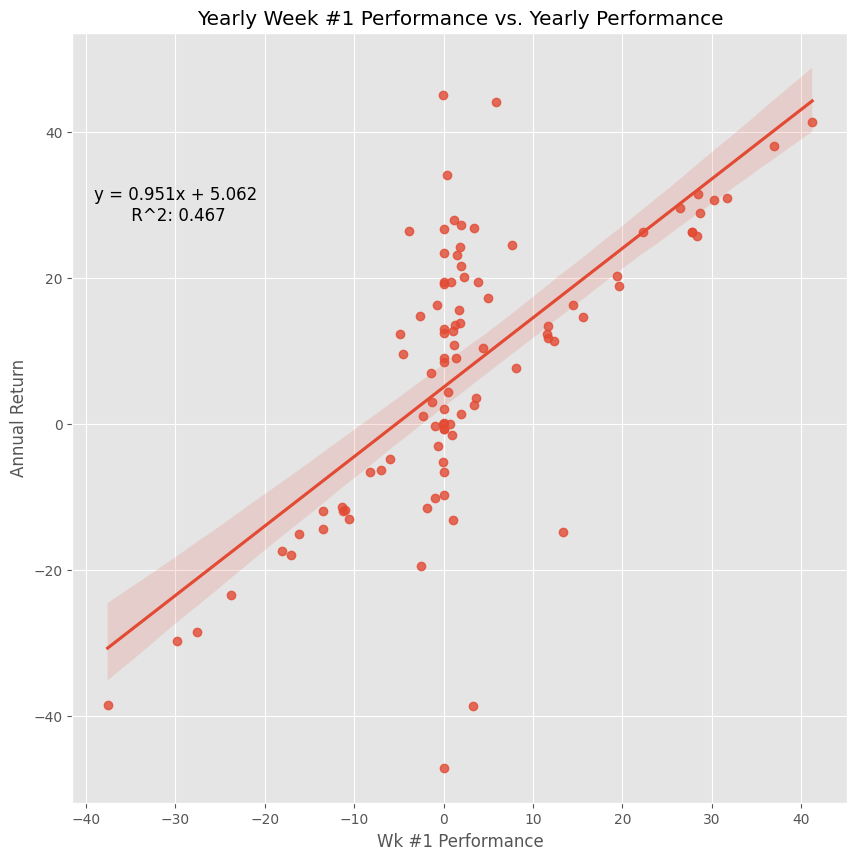

In [ ]:
#Finding correlation between price change during 1st week of year and yearly price return
df = w_df[w_df["Wk"] == 1].drop(['Wk_open','Wk_end','Wk_avg','Wk_median'],axis = 1)
df2 = yr_df[["Year","P_yr"]]

df3 = pd.merge(df,df2, on = "Year").drop(index=0) # dropped 1950 since P_yr = NaN

pearson_coef, p_value = stats.pearsonr(df3['P_wk'], df3['P_yr'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value,
      "\nIndicating the linear relationship is positive and moderately strong.",
      "Also, note that these variable are not truly independent since the weekly data is also part of the yearly data calculation.\n")

lm = LinearRegression() # create instance of linear regression model
lm.fit(df3[['P_wk']], df3['P_yr']) # fit model to data
r2 = lm.score(df3[['P_wk']], df3['P_yr']) # Calculate R^2 of linear regression
slope = lm.coef_[0]
intercept = lm.intercept_

#plot figure with regression and equation
plt.figure(figsize = (10,10))
plt.title("Yearly Week #1 Performance vs. Yearly Performance")
plt.text(-30, 30, "y = {0:.3f}x + {1:.3f}\n R^2: {2:.3f}".format(slope,intercept,r2), fontsize = 12, wrap = True,
                 horizontalalignment='center', verticalalignment='center')
s = sns.regplot(x="P_wk",y="P_yr", data = df3)
s.set(xlabel = "Wk #1 Performance", ylabel = "Annual Return")

In [ ]:
print("The Top 10 Monthly gains are: \n")
m_df.sort_values(by=['P_mnth','M_nm'],ascending=False).head(11).reset_index(drop=True).shift()[1:]

The Top 10 Monthly gains are: 



,Year,M_nm,M_open,M_end,M_avg,M_median,P_mnth
1,1932.0,August,6.110000,8.390000,7.516087,7.600000,37.315878
2,1933.0,April,5.870000,7.830000,6.870526,6.660000,33.390121
3,1932.0,July,4.600000,6.030000,4.974500,4.810000,31.086964
4,1938.0,June,9.570000,11.560000,10.229091,9.780000,20.794157
5,1931.0,June,12.400000,14.830000,13.836818,13.645000,19.596777
6,2020.0,April,2470.500000,2912.429932,2761.975226,2797.800049,17.888279
7,1974.0,October,63.389999,73.900002,69.435652,70.330002,16.579906
8,1933.0,May,8.430000,9.640000,8.869091,8.835000,14.353499
9,2011.0,October,1099.229980,1253.300049,1207.216187,1209.880005,14.016181
10,2009.0,March,700.820007,797.869995,757.126814,762.544983,13.848062


In [ ]:
print("The Top 10 Monthly losses are: \n")
m_df.sort_values(by=['P_mnth','M_nm']).head(11).reset_index(drop=True).shift()[1:]

The Top 10 Monthly losses are: 



,Year,M_nm,M_open,M_end,M_avg,M_median,P_mnth
1,1931.0,September,13.920000,9.710000,11.890000,11.990000,-30.244253
2,1938.0,March,11.460000,8.500000,10.307391,10.580000,-25.828971
3,1987.0,October,327.329987,251.789993,280.164092,290.389999,-23.077627
4,1940.0,May,12.030000,9.270000,10.552273,10.330000,-22.942638
5,1932.0,May,5.740000,4.470000,5.522381,5.600000,-22.125436
6,1929.0,October,29.980000,24.150000,27.991304,28.950001,-19.446298
7,1932.0,April,7.180000,5.830000,6.269524,6.120000,-18.802228
8,2008.0,October,1161.060059,968.750000,968.800874,954.090027,-16.563317
9,2020.0,March,3090.229980,2584.590088,2652.393632,2605.619995,-16.362533
10,1930.0,June,24.400000,20.459999,21.600476,20.790001,-16.147543


In [ ]:
print("The Top 10 Yearly gains are: \n")
yr_df.sort_values(by=['P_yr','Year'],ascending=False).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Avg_close','Max_date','Min_date'], axis = 1)

The Top 10 Yearly gains are: 



,Year,Max_close,Min_close,Med_close,Yr_open,Yr_end,P_yr
1,1954.0,35.980000,24.799999,29.510000,24.950001,35.980000,45.022170
2,1933.0,12.200000,5.530000,9.695000,6.830000,9.970000,44.075147
3,1935.0,13.460000,8.060000,10.365000,9.510000,13.430000,41.368424
4,1958.0,55.209999,40.330002,45.210001,40.330002,55.209999,38.059507
5,1928.0,24.350000,16.950001,19.545000,17.760000,24.350000,37.882223
6,1995.0,621.690002,459.109985,548.485016,459.109985,615.929993,34.110655
7,1975.0,95.610001,70.040001,87.120003,70.230003,90.190002,31.549016
8,1997.0,983.789978,737.010010,898.700012,737.010010,970.429993,31.008182
9,1945.0,17.680000,13.210000,14.865000,13.330000,17.360001,30.722899
10,2013.0,1848.359985,1457.150024,1650.404968,1462.420044,1848.359985,29.601250


In [ ]:
print("The Top 10 Yearly losses are: \n")
yr_df.sort_values(by=['P_yr','Year']).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Avg_close','Max_date','Min_date'], axis = 1)

The Top 10 Yearly losses are: 



,Year,Max_close,Min_close,Med_close,Yr_open,Yr_end,P_yr
1,1931.0,18.170000,7.720000,13.980000,15.850000,8.120000,-47.066494
2,1937.0,18.670000,10.170000,16.265000,16.930000,10.550000,-38.591385
3,2008.0,1447.160034,752.440002,1289.189941,1447.160034,903.250000,-38.485793
4,1974.0,99.800003,62.279999,84.989998,97.680000,68.559998,-29.718098
5,1930.0,25.920000,14.440000,21.370001,21.180000,15.340000,-28.484850
6,2002.0,1172.510010,776.760010,971.090027,1154.670044,879.820007,-23.365964
7,2022.0,4796.560059,3577.030029,4027.260010,4796.560059,3839.500000,-19.442827
8,1941.0,10.860000,8.370000,9.900000,10.480000,8.690000,-17.863898
9,1973.0,120.239998,92.160004,107.514999,119.099998,97.550003,-17.365523
10,1940.0,12.770000,8.990000,10.730000,12.630000,10.580000,-15.088283


In [ ]:
print("The average yearly return for the {0} is {1:.2f}%".format(tckr.info["shortName"],yr_df['P_yr'].mean()))

The average yearly return for the S&P 500 is 7.77%


In [ ]:
#Sorted datatable for year greater than or equal to 1991
print("The Top 10 Extended trading hour gains are: \n")
data[data['Year'] >=1991].sort_values(by=['PEx_trd','Year'],ascending=False).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','M_num','M_nm','D_num','Year','Wk','Ex_trd'], axis = 1)

The Top 10 Extended trading hour gains are: 



,Date,Open,High,Low,Close,D_nm,P_intra,P_day,P_Vol,PEx_trd
1,2020-03-24 00:00:00-04:00,2344.439941,2449.709961,2344.439941,2447.330078,Tuesday,4.490199,4.388687,2.047797,4.784126
2,2020-03-13 00:00:00-04:00,2569.989990,2711.330078,2492.370117,2711.020020,Friday,8.785210,5.487571,-6.233780,3.601897
3,2020-04-06 00:00:00-04:00,2578.280029,2676.850098,2574.570068,2663.679932,Monday,3.972703,3.312282,5.033156,3.601556
4,2022-11-10 00:00:00-05:00,3859.889893,3958.330078,3859.889893,3956.370117,Thursday,2.550337,2.499559,24.461734,2.969661
5,2020-04-07 00:00:00-04:00,2738.649902,2756.889893,2657.669922,2659.409912,Tuesday,3.733344,-2.893396,10.096598,2.814526
6,2020-03-10 00:00:00-04:00,2813.479980,2882.590088,2734.000000,2882.229980,Tuesday,5.434897,2.443593,-9.468340,2.436499
7,2020-06-12 00:00:00-04:00,3071.040039,3088.419922,2984.469971,3041.310059,Friday,3.483029,-0.968075,-16.938124,2.296390
8,2020-06-16 00:00:00-04:00,3131.000000,3153.449951,3076.060059,3124.739990,Tuesday,2.515877,-0.199936,1.534178,2.100376
9,2020-11-09 00:00:00-05:00,3583.040039,3645.989990,3547.479980,3550.500000,Monday,2.776901,-0.908168,76.986697,2.097204
10,2022-12-13 00:00:00-05:00,4069.379883,4100.959961,3993.030029,4019.649902,Tuesday,2.702958,-1.222053,30.102225,1.975157


In [ ]:
print("The Top 10 Extended trading hour losses are: \n")
data[data['Year'] >=1991].sort_values(by=['PEx_trd','Year']).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','M_num','M_nm','D_num','Year','Wk','Ex_trd'], axis = 1)

The Top 10 Extended trading hour losses are: 



,Date,Open,High,Low,Close,D_nm,P_intra,P_day,P_Vol,PEx_trd
1,2020-03-16 00:00:00-04:00,2508.590088,2562.979980,2380.939941,2386.129883,Monday,7.645722,-4.881635,-5.947895,-7.466929
2,2020-03-12 00:00:00-04:00,2630.860107,2660.949951,2478.860107,2480.639893,Thursday,7.345709,-5.709928,19.103375,-4.031538
3,2020-03-18 00:00:00-04:00,2436.500000,2453.570068,2280.520020,2398.100098,Wednesday,7.588184,-1.576027,5.125892,-3.664807
4,2020-03-09 00:00:00-04:00,2863.889893,2863.889893,2734.429932,2746.560059,Monday,4.734441,-4.096870,28.771639,-3.649620
5,2020-04-01 00:00:00-04:00,2498.080078,2522.750000,2447.489990,2470.500000,Wednesday,3.074987,-1.104051,-9.309465,-3.347146
6,2020-03-27 00:00:00-04:00,2555.870117,2615.909912,2520.020020,2541.469971,Friday,3.805124,-0.563415,-20.153496,-2.821216
7,2020-02-24 00:00:00-05:00,3257.610107,3259.810059,3214.649902,3225.889893,Monday,1.404823,-0.973727,24.109313,-2.401015
8,2020-03-06 00:00:00-05:00,2954.199951,2985.929932,2901.540039,2972.370117,Friday,2.908452,0.615062,17.492369,-2.306262
9,2020-06-11 00:00:00-04:00,3123.530029,3123.530029,2999.489990,3002.100098,Thursday,4.135371,-3.887586,6.644319,-2.087992
10,2020-02-28 00:00:00-05:00,2916.899902,2959.719971,2855.840088,2954.219971,Friday,3.637454,1.279443,21.301087,-2.076707


The Pearson Correlation Coefficient is 0.244 with a P-value of P = 2.8399391676630446e-66 
Indicating a small linear relationship between after hour trading and daily price changes.


[Text(0.5, 0, 'After hour trading'), Text(0, 0.5, 'Next Day Performance')]

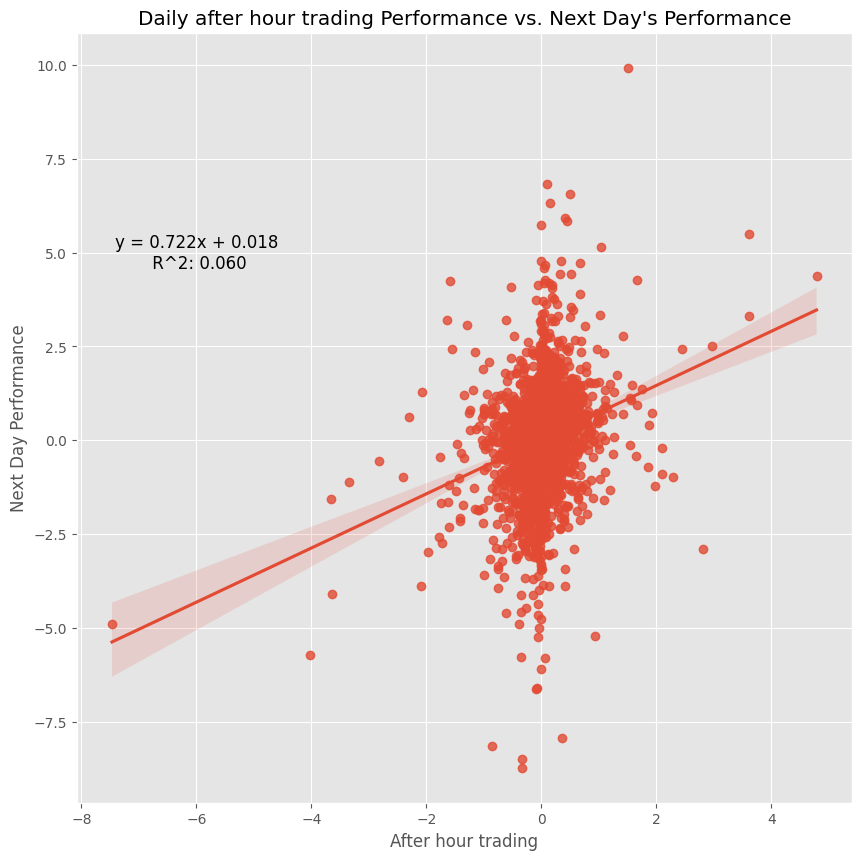

In [ ]:
df4 = data[data['Year'] >=1991].dropna() # dropped years before 1991 and NaN values

pearson_coef, p_value = stats.pearsonr(df4['PEx_trd'], df4['P_day'])
print("The Pearson Correlation Coefficient is", round(pearson_coef,3), "with a P-value of P =", p_value,
      "\nIndicating a small linear relationship between after hour trading and daily price changes.")

lm = LinearRegression() # create instance of linear regression model
lm.fit(df4[['PEx_trd']], df4['P_day']) # fit model to data
r2 = lm.score(df4[['PEx_trd']], df4['P_day']) # Calculate R^2 of linear regression
slope = lm.coef_[0]
intercept = lm.intercept_

#plot figure with regression and equation
plt.figure(figsize = (10,10))
plt.title("Daily after hour trading Performance vs. Next Day's Performance")
plt.text(-6, 5, "y = {0:.3f}x + {1:.3f}\n R^2: {2:.3f}".format(slope,intercept,r2), fontsize = 12, wrap = True,
                 horizontalalignment='center', verticalalignment='center')
s = sns.regplot(x="PEx_trd",y="P_day", data = df4)
s.set(xlabel = "After hour trading", ylabel = "Next Day Performance")

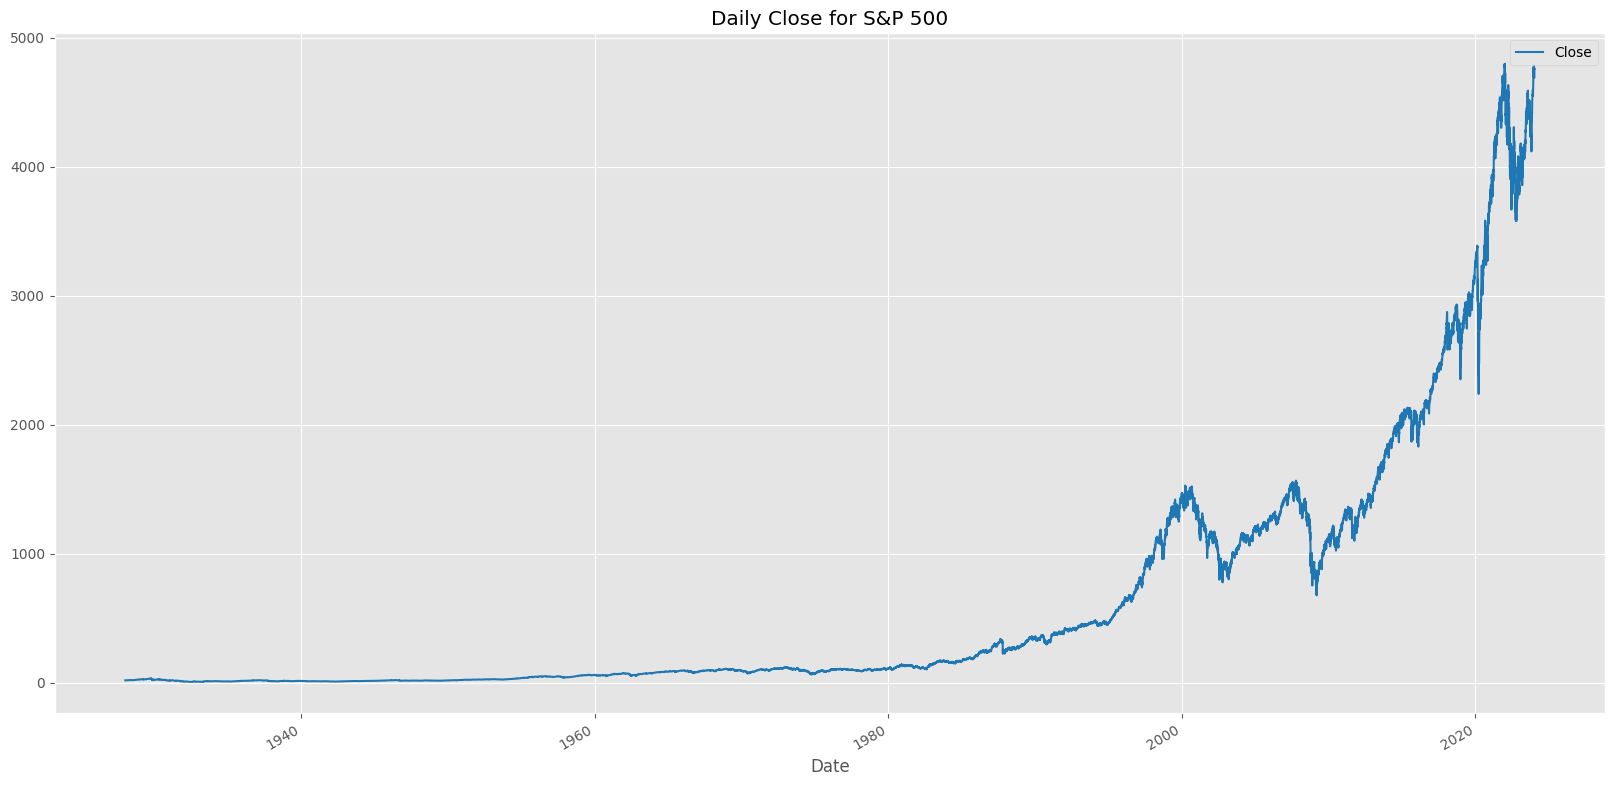

In [ ]:
# Display line plot of S&P 500 Closing value vs Date
data.plot(x="Date",y="Close",title = "Daily Close for S&P 500",figsize = (20,10),colormap= 'tab10')
plt.show()

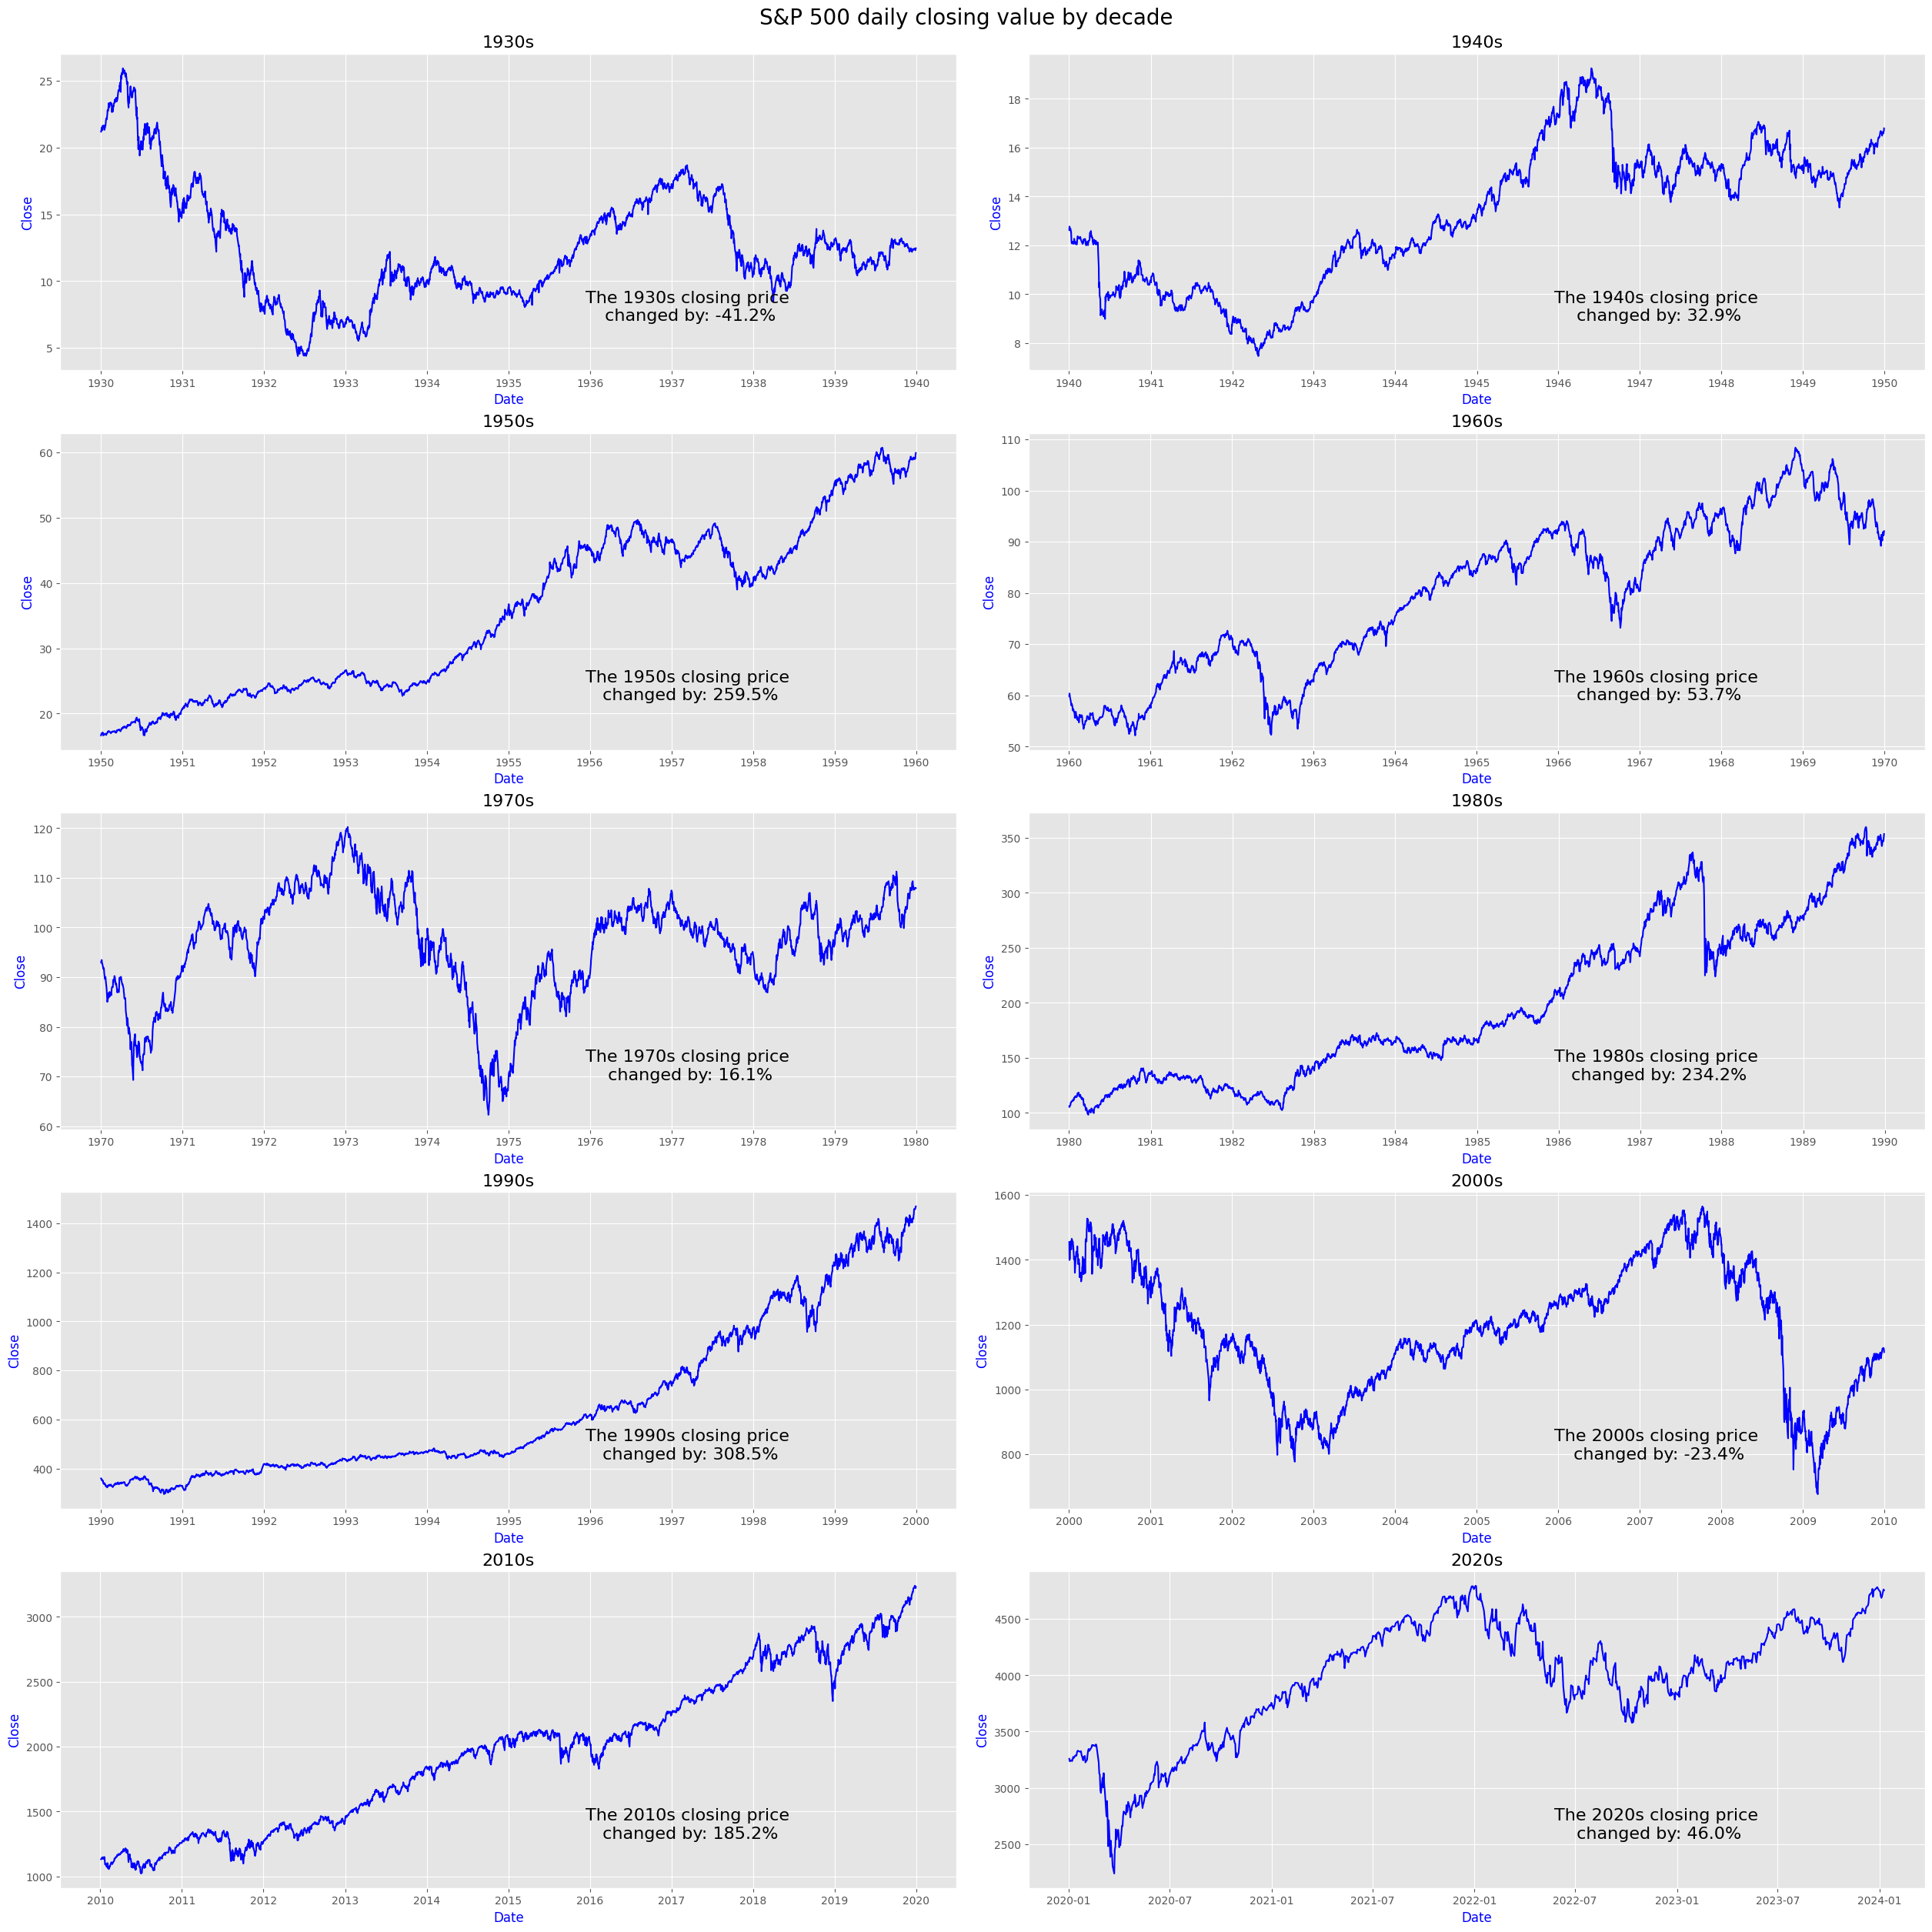

In [ ]:
## find year that are divisible by 10
decade = list(data[data['Year']%10 == 0]['Year'].unique())

#Create figure for subplots
fig,ax = plt.subplots(nrows = int(round(len(decade)/2)), ncols =2, figsize=(25,25), constrained_layout=True)
plt.suptitle("S&P 500 daily closing value by decade",fontsize = 20)

#Loop through each row and column to create plot for each decade
i = 0
for row in ax:
    for col in row:
        start = decade[i]
        if i == (len(decade) - 1): #If at last 10s then just pull last 'year' from dataframe
            end = data['Year'].tail(1).loc[0:'Year'].iloc[0]+1
        else:
            end = decade[i+1]

        #Set title for plot
        col.set_title(str(start)+'s', fontsize = 16)

        #Pull data for each decade
        x = data[(data['Year'] >= start) & (data['Year'] < end )]['Date'].dt.date
        y = data[(data['Year'] >= start) & (data['Year'] < end )]['Close']

        #Plot closing data, set title and axes labels
        col.plot(x,y,'-b')
        col.set_xlabel("Date", color = 'blue')
        col.set_ylabel("Close", color = 'blue')

        gain = p_chg(y.iloc[0],y.iloc[-1]) #Calculate decade gain from first trading day until last trading day
        col.text(0.7, 0.2, "The {0}s closing price\n changed by: {1:.1f}%".format(start,gain), fontsize = 16, wrap = True,
                 horizontalalignment='center', verticalalignment='center', transform=col.transAxes)
        i += 1
        if i == len(decade): #Once index equals length of decade list stop iterating through loop
            break

plt.show()

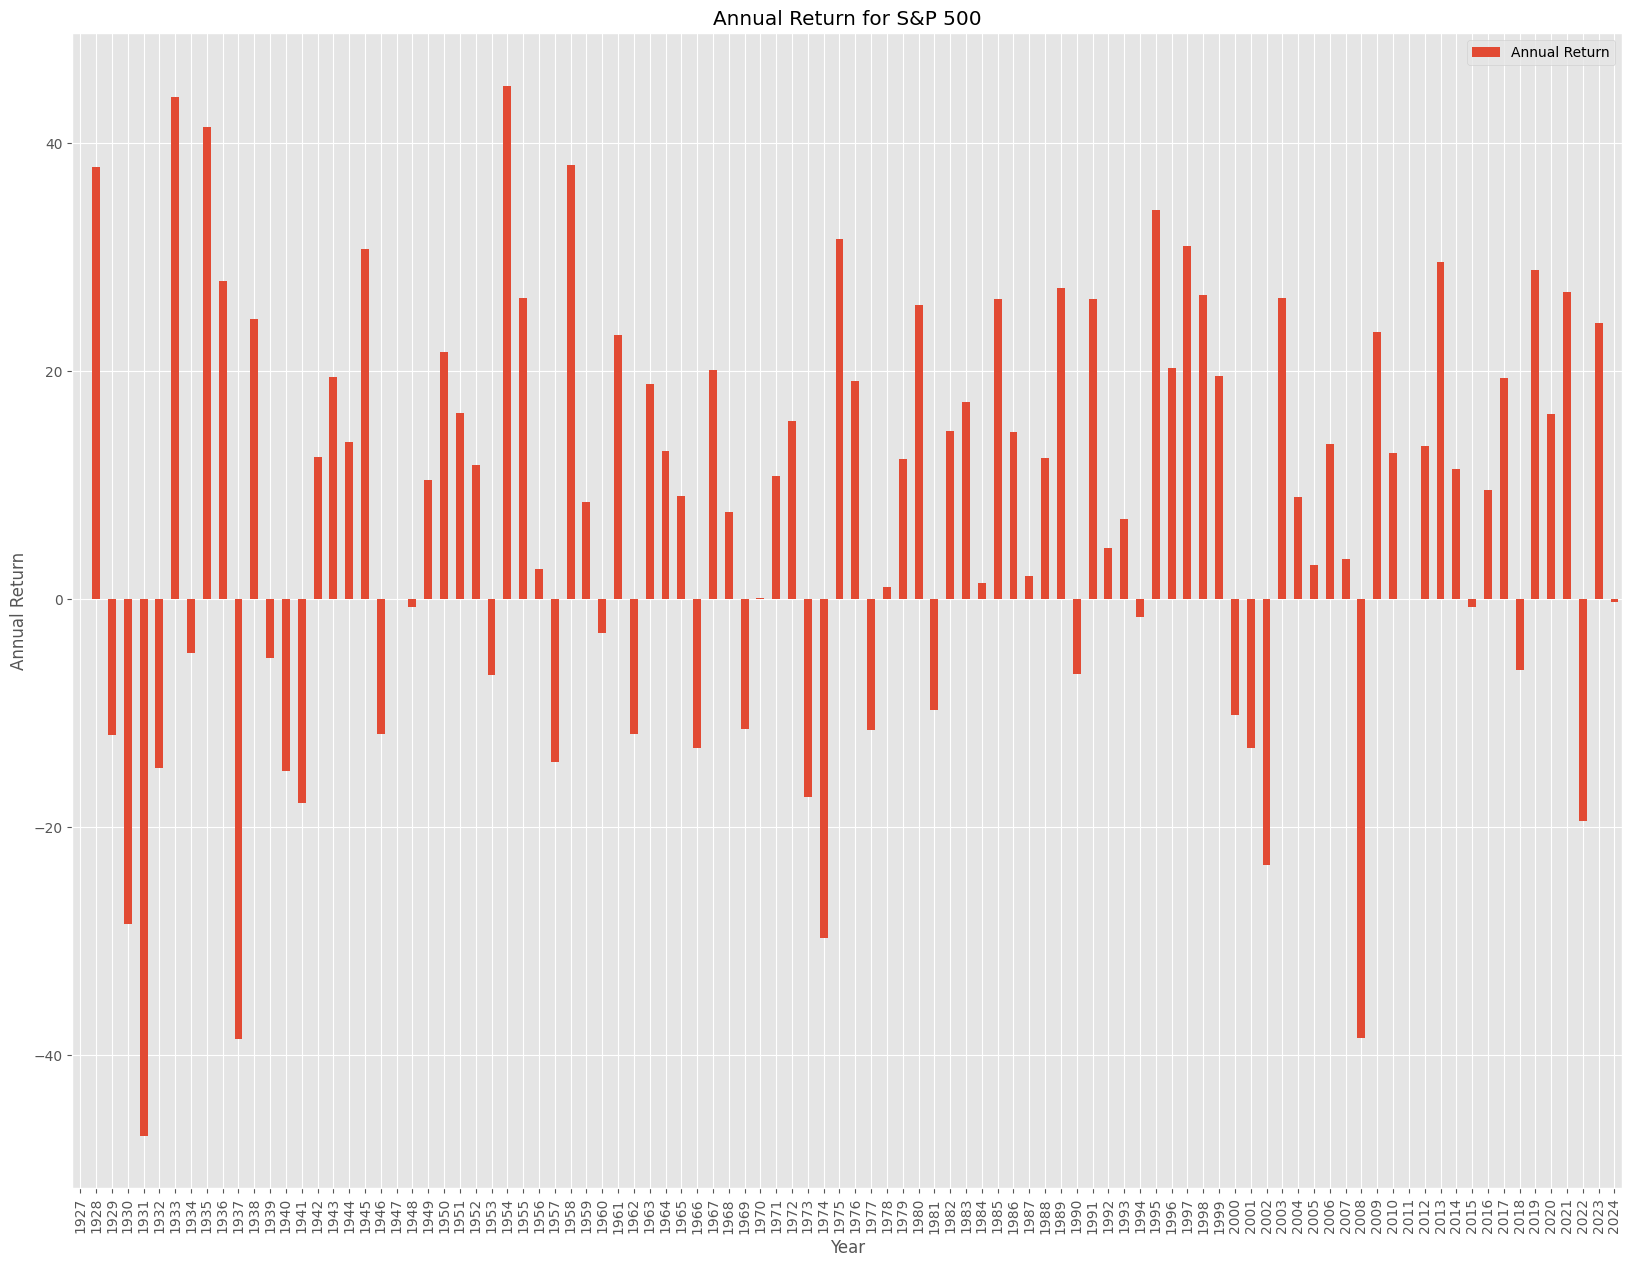

In [ ]:
yr_df.plot.bar(x='Year',y='P_yr',color='C0', label='Annual Return', figsize = (20,15))

plt.title('Annual Return for S&P 500')

plt.ylabel("Annual Return")
plt.xlabel("Year")

plt.show()

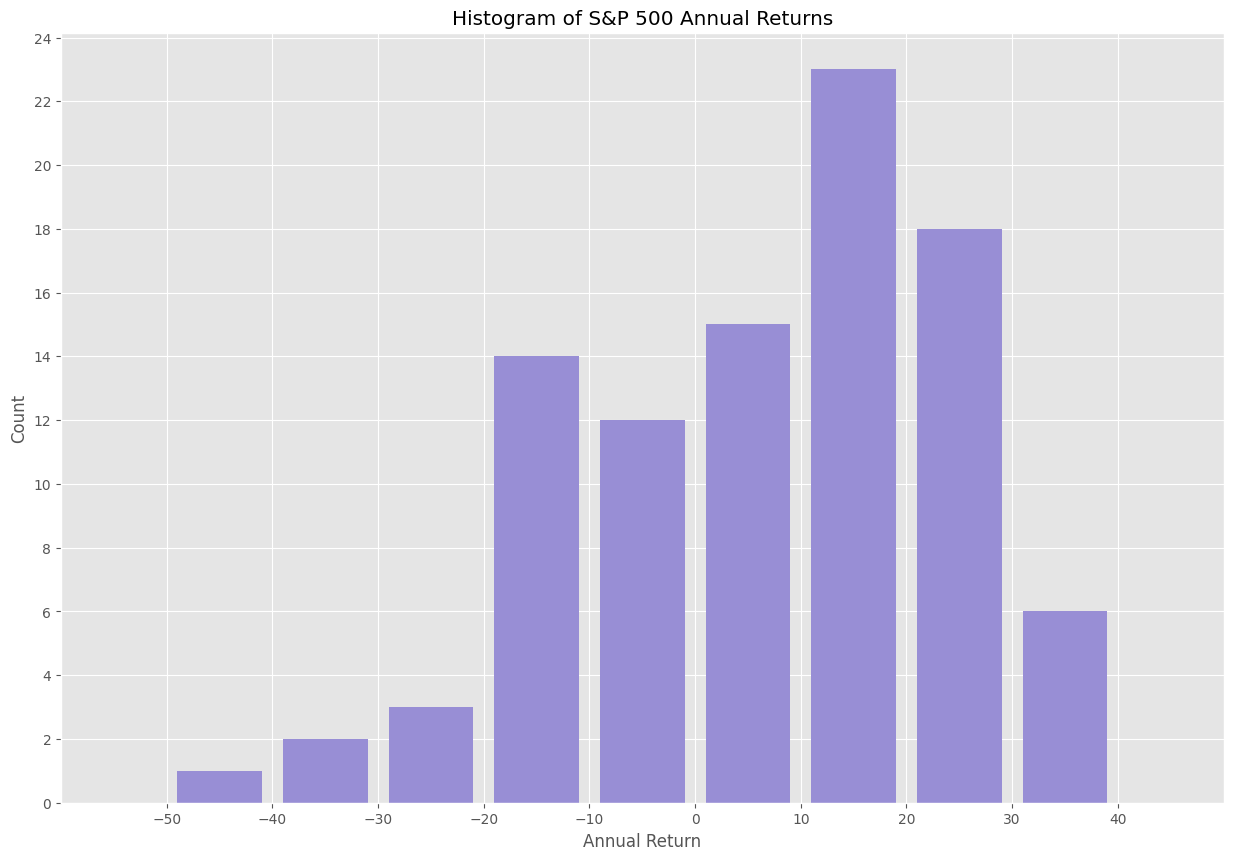

In [ ]:
#getting high and low bounds for chart
high = int(round(yr_df['P_yr'].max()/10,0))*10
low = int(round(yr_df['P_yr'].min()/10,0))*10

#creating bins and setting bin width
count, bin_edges = np.histogram(yr_df.loc[1:,'P_yr'],bins=(range(low,high,10)))
x_min = bin_edges[0] - 10
x_max = bin_edges[-1] + 10

#Find max count a round up to nearest even number
if (count.max()%2 == 0):
    ymax = 20
else:
    ymax = count.max() +2

#Plot histogram of annual returns
yr_df.loc[1:,'P_yr'].plot.hist(bins=(range(low,high,10)), color='C9', figsize = (15,10), xticks = bin_edges,
                               xlim = (x_min,x_max), yticks =range(0,ymax,2), rwidth = 0.8)
plt.xlabel("Annual Return")
plt.ylabel("Count")
plt.title("Histogram of S&P 500 Annual Returns")
plt.show()

In [ ]:
print("Out of {0} years worth of data, there has only been {1} years where the annual return has been less than -20%. But there have been {2} years (or {4:.2%}) with \
an annual return greater than 0% and {3} (or {5:.2%}) years with an annual return greater than 6% (30 year treasury yield in 2000)."
      .format(yr_df['Year'].count(),yr_df[yr_df['P_yr'] < -20].value_counts().count(),
              yr_df[yr_df['P_yr'] > 0].value_counts().count(),yr_df[yr_df['P_yr'] > 6].value_counts().count(),
             yr_df[yr_df['P_yr'] > 0].value_counts().count()/yr_df['Year'].count(),yr_df[yr_df['P_yr'] > 6].value_counts().count()/yr_df['Year'].count()))

Out of 98 years worth of data, there has only been 6 years where the annual return has been less than -20%. But there have been 64 years (or 65.31%) with an annual return greater than 0% and 56 (or 57.14%) years with an annual return greater than 6% (30 year treasury yield in 2000).


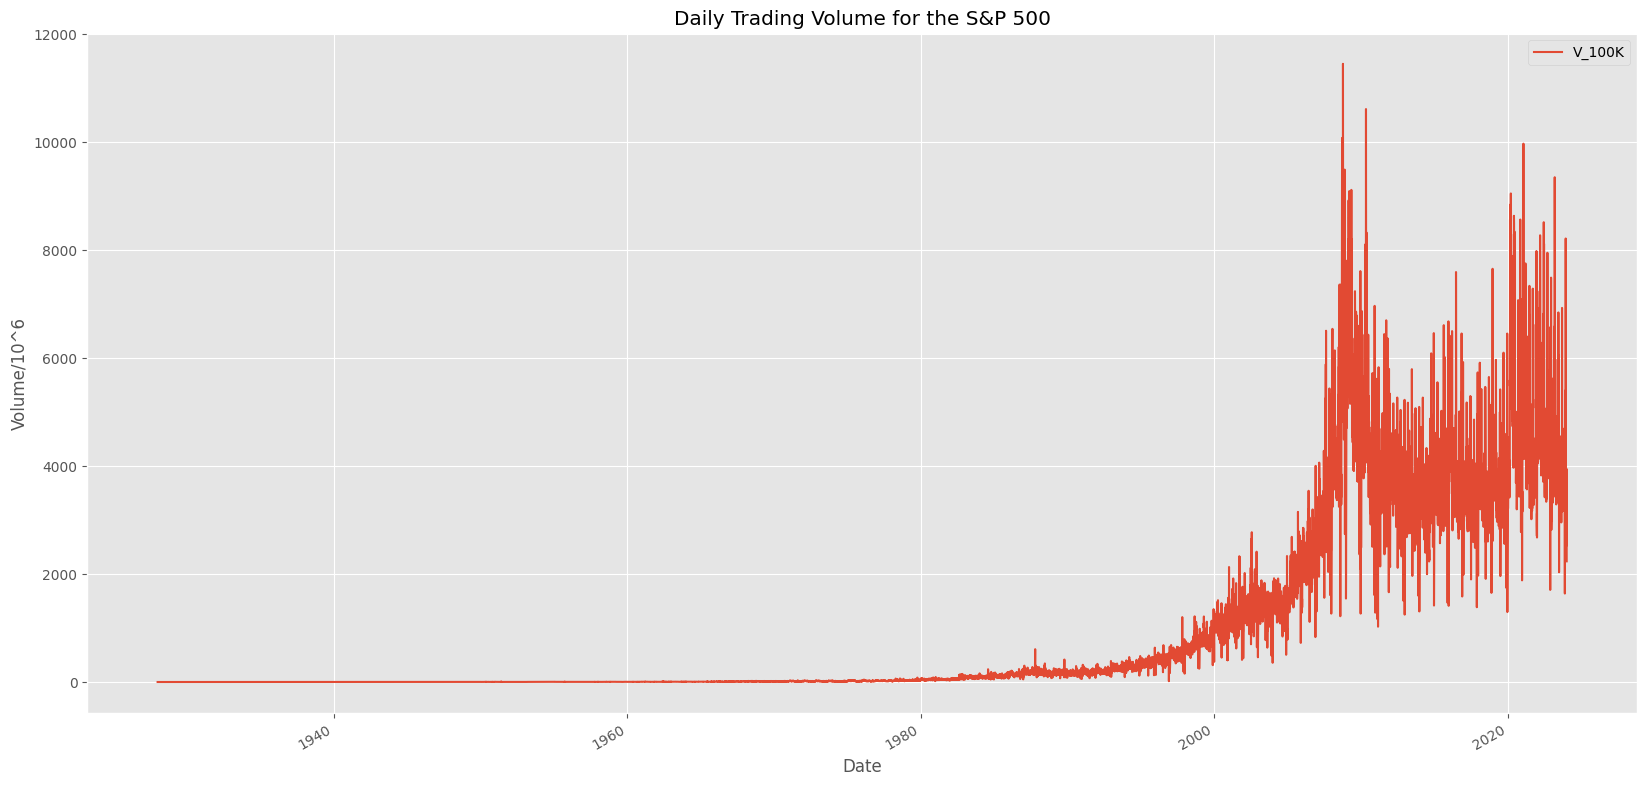

In [ ]:
yr_vol = data[["Date",'Volume']]
yr_vol = yr_vol.assign(V_100K = round(yr_vol['Volume']/(10**6),3))
yr_vol.drop(columns='Volume')

yr_vol.plot(x="Date",y="V_100K",title = "Daily Trading Volume for the S&P 500", figsize = (20,10))
plt.ylabel("Volume/10^6")
plt.xlabel("Date")

plt.show()

<ipython-input-7-7f5ee41924b9>:10: RuntimeWarning: invalid value encountered in double_scalars
  y = ((x2-x1)/x1)*100


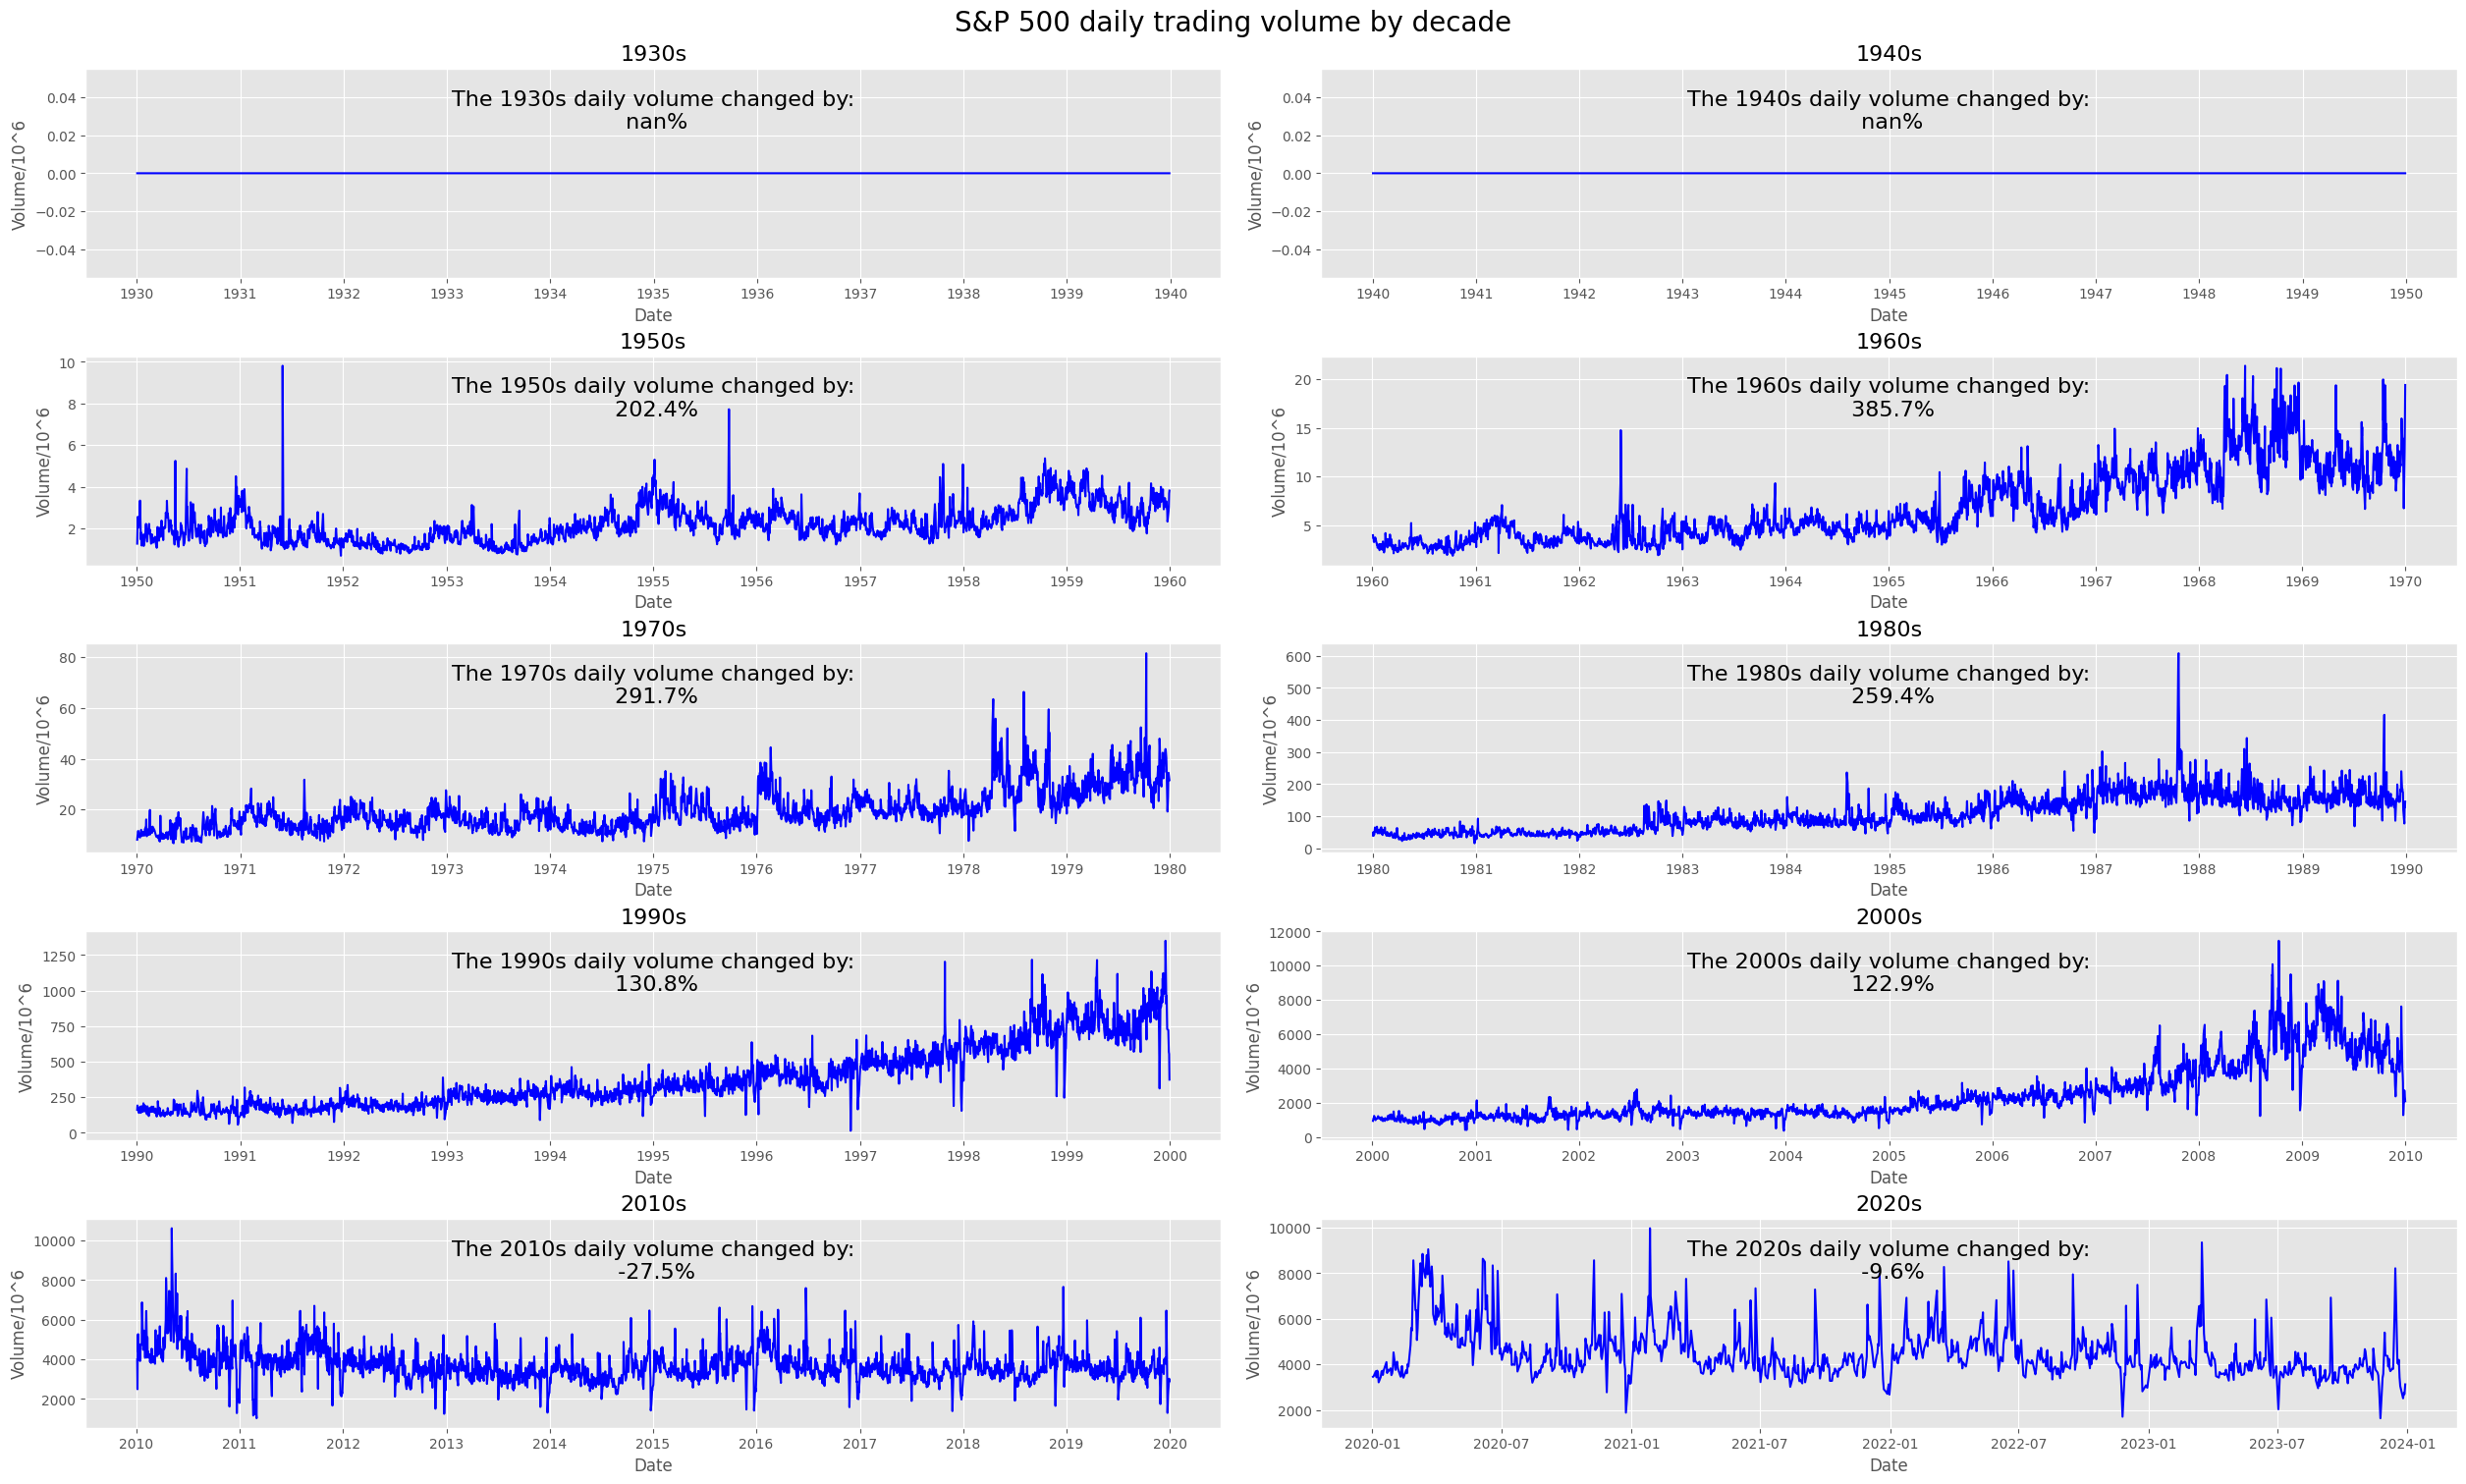

In [ ]:
## find year that are divisible by 10
decade = list(data[data['Year']%10 == 0]['Year'].unique())

#Create figure for subplots
fig,ax = plt.subplots(nrows = int(round(len(decade)/2)), ncols =2, figsize=(25,15), constrained_layout=True)
plt.suptitle("S&P 500 daily trading volume by decade",fontsize = 20)

i = 0
for row in ax:
    for col in row:
        start = decade[i]
        if i == (len(decade) - 1):
            end = data['Year'].tail(1).loc[0:'Year'].iloc[0]
        else:
            end = decade[i+1]
        x = data[(data['Year'] >= start) & (data['Year'] < end )]['Date']
        y = data[(data['Year'] >= start) & (data['Year'] < end )]['Volume']/(10**6)
        col.plot(x,y, color = 'blue')
        col.set_title(str(start)+'s', fontsize = 16)
        col.set_xlabel("Date")
        col.set_ylabel("Volume/10^6")
        gain = p_chg(y.iloc[0],y.iloc[-1])
        col.text(0.5, 0.8, "The {0}s daily volume changed by:\n {1:.1f}%".format(start,gain), fontsize = 16, wrap = True,
                 horizontalalignment='center', verticalalignment='center', transform=col.transAxes)
        i += 1
        if i == len(decade):
            break

plt.show()

Text(0, 0.5, 'Daily Percent Return')

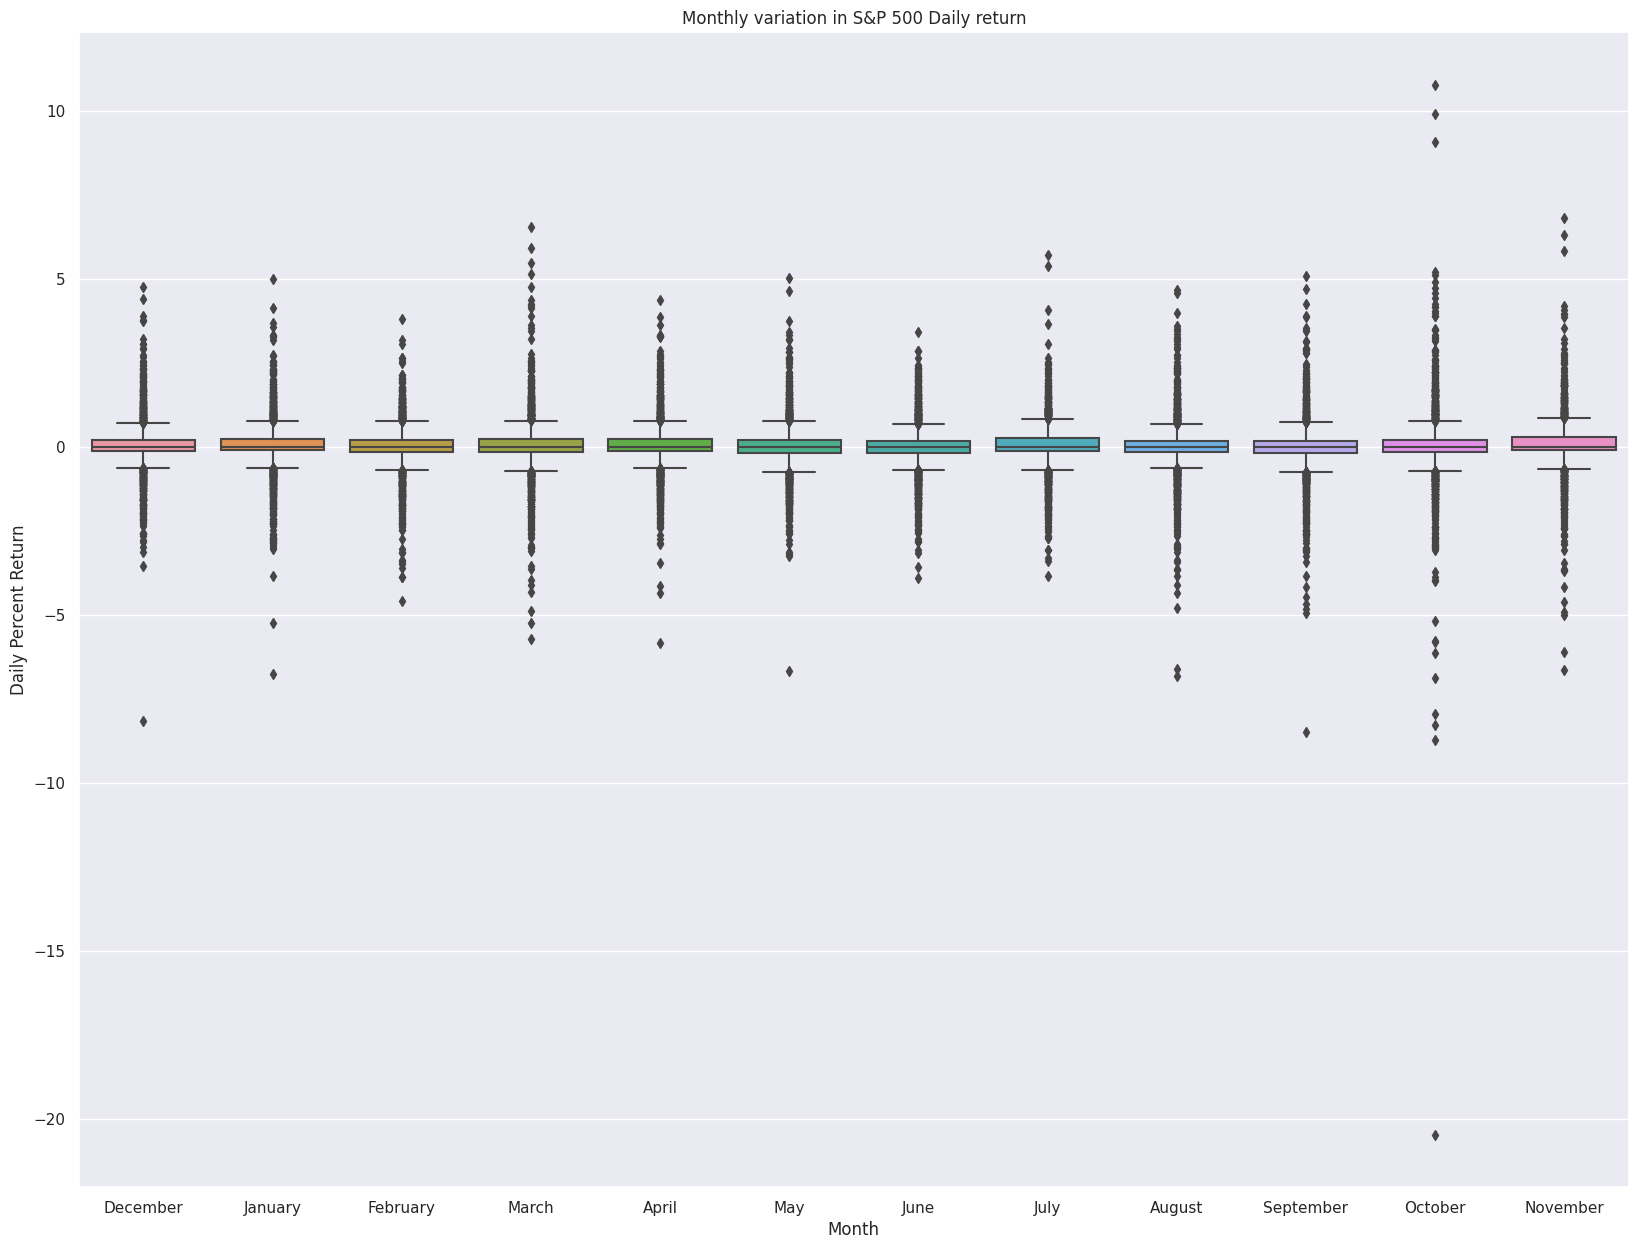

In [ ]:
#Display box plot for each month showing percent changes per day
sns.set(rc = {'figure.figsize':(20,15)}) #Set figure size

sns.boxplot(x='M_nm',y='P_day', data =data)
plt.title("Monthly variation in S&P 500 Daily return")
plt.xlabel("Month")
plt.ylabel("Daily Percent Return")



Text(0, 0.5, 'Daily Percent Return')

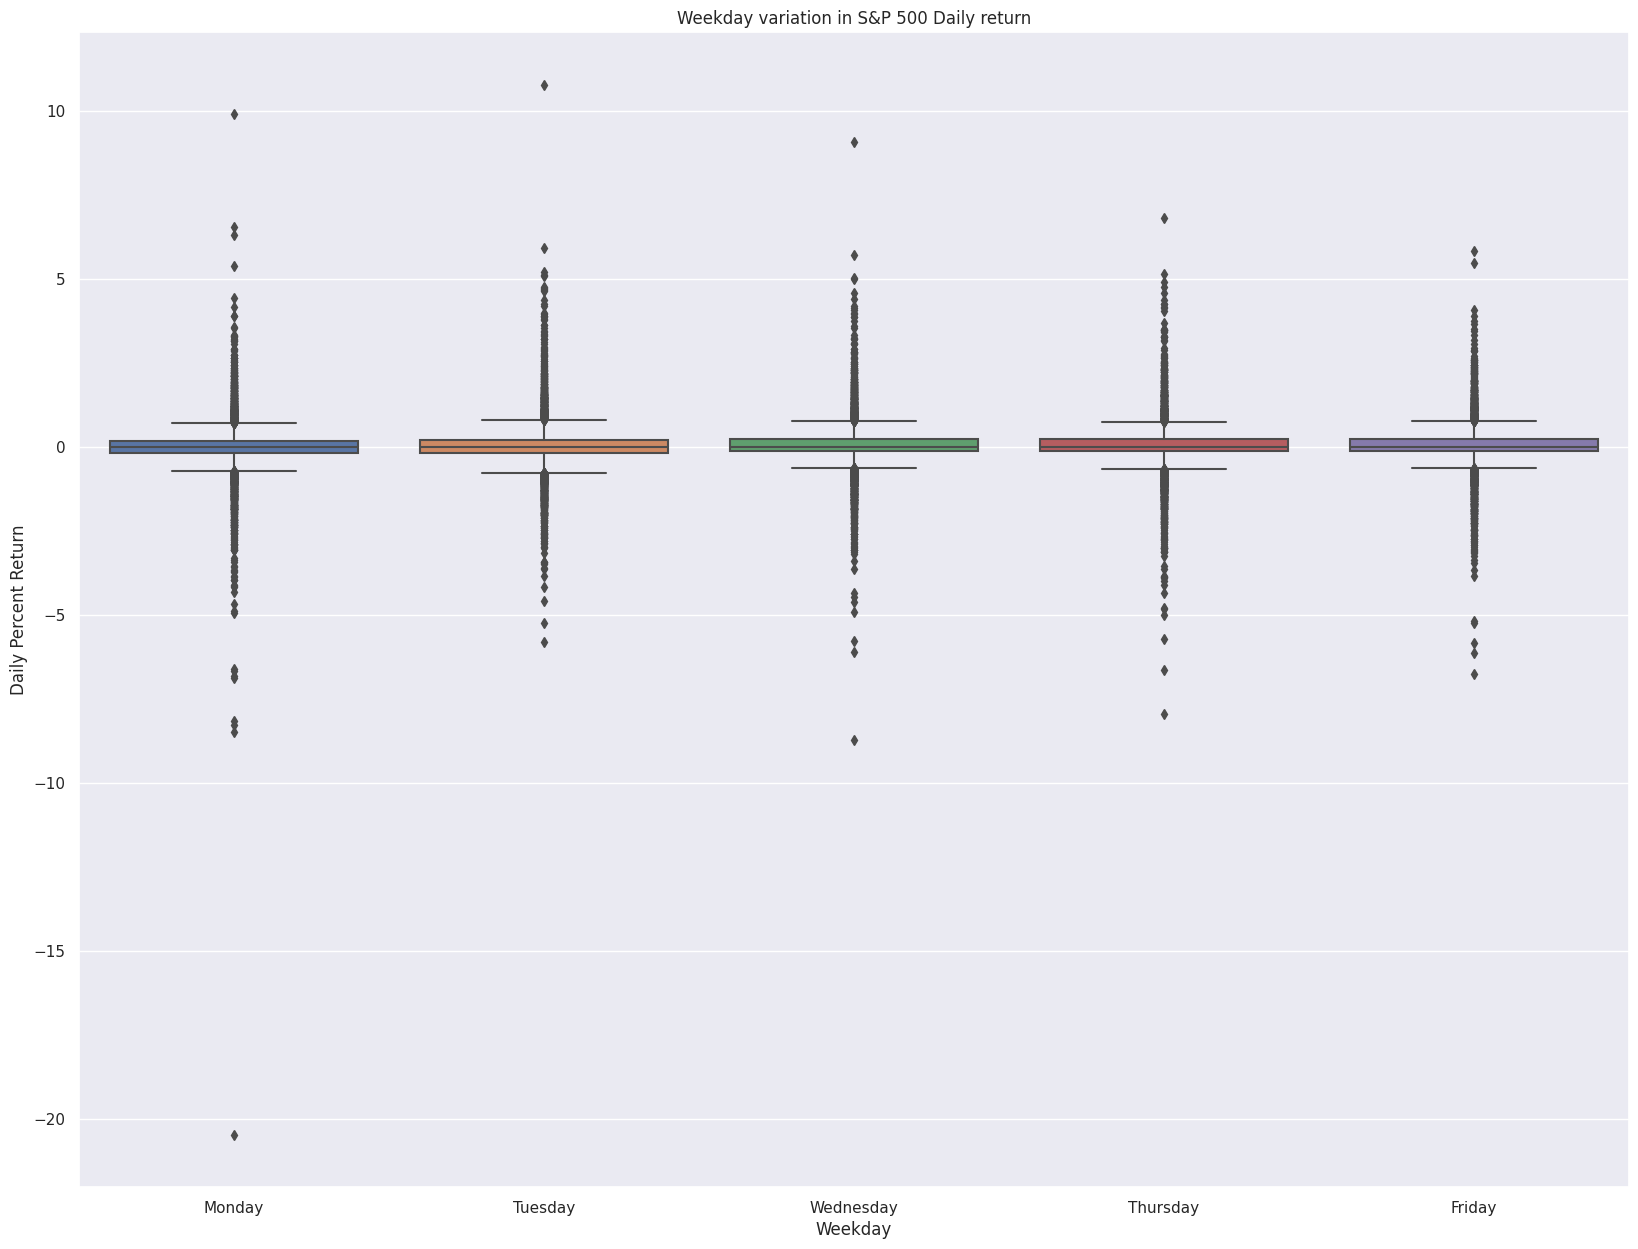

In [ ]:
#Display box plot for each month showing percent changes per day
index_dy = ['Monday','Tuesday','Wednesday','Thursday','Friday'] # Reorder index
sns.set(rc = {'figure.figsize':(20,15)}) #Set figure size
sns.boxplot(x='D_nm',y='P_day', data =data, order = index_dy)

plt.title("Weekday variation in S&P 500 Daily return")
plt.xlabel("Weekday")
plt.ylabel("Daily Percent Return")

Text(0, 0.5, 'Daily Percent Return')

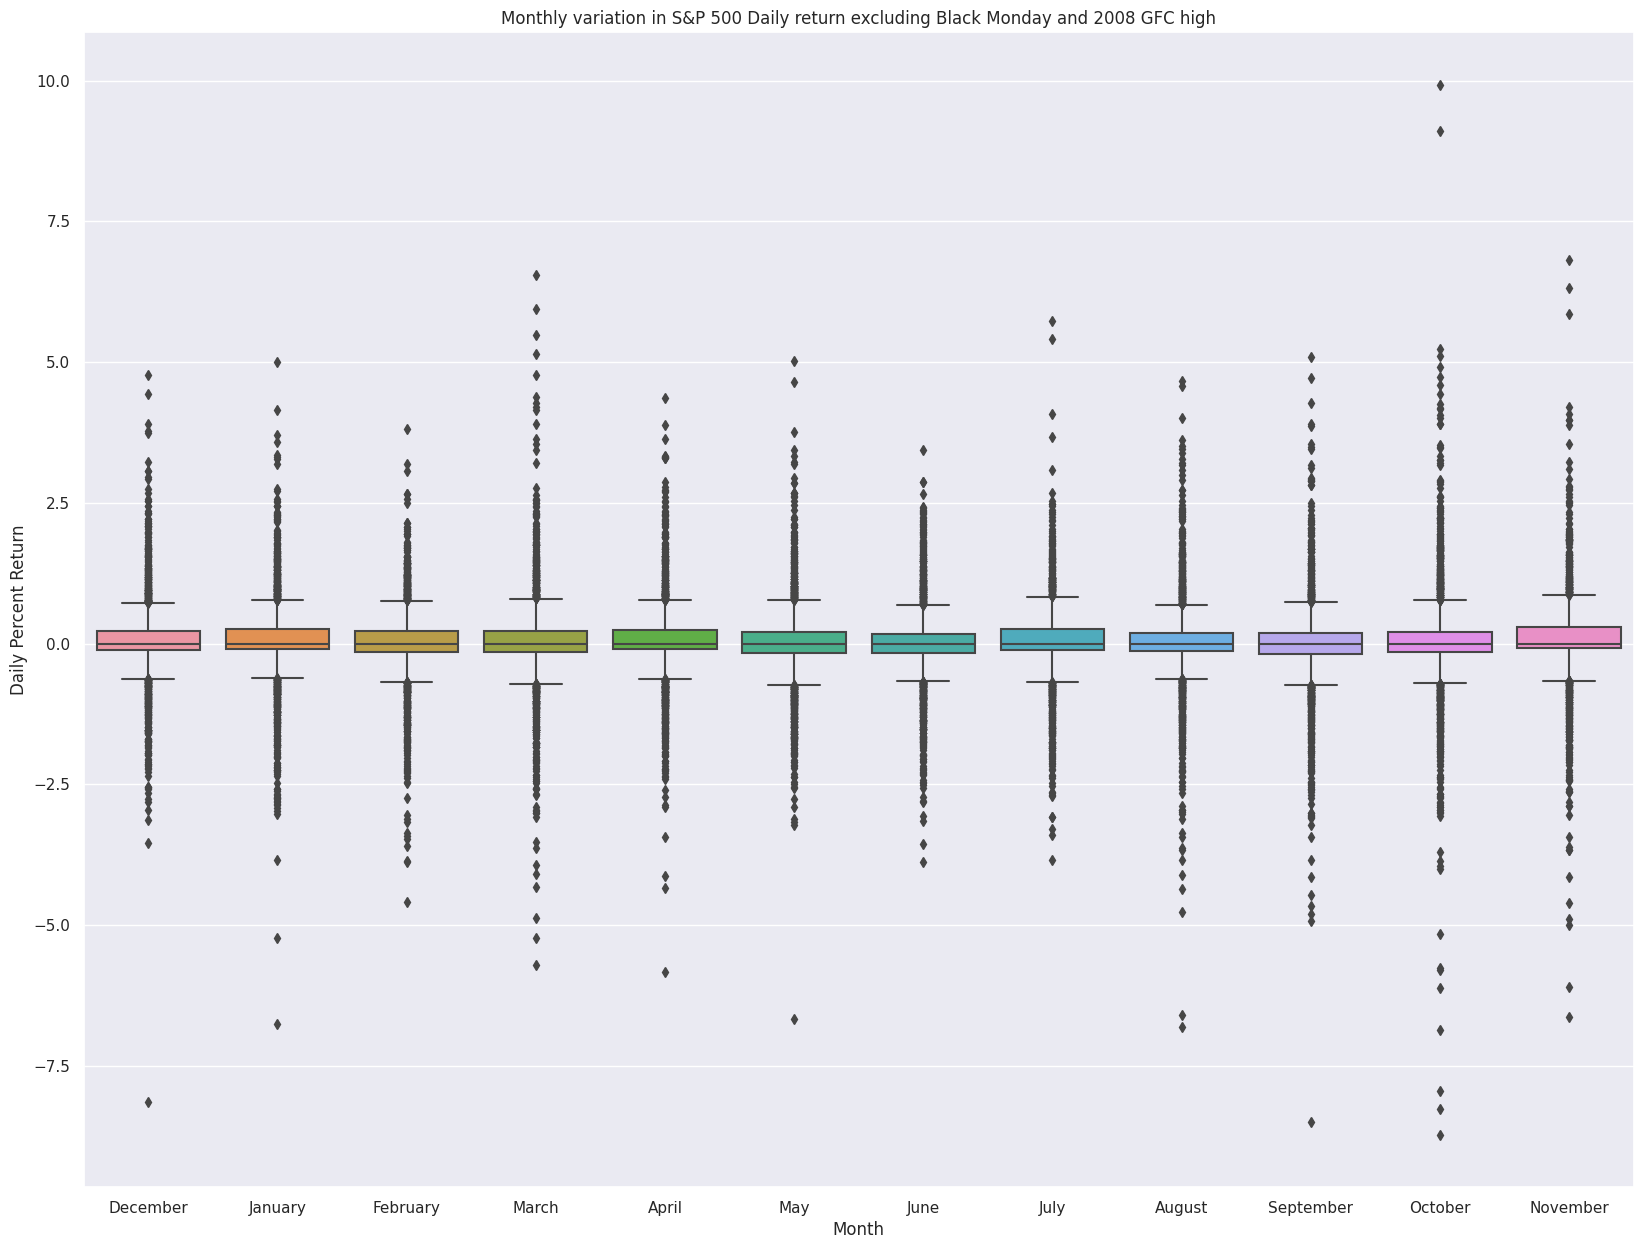

In [ ]:
# Remove Black Friday and 2008 GFC data from mnth_df
# find index value for both October max and min
mth_max = data[(data['P_day'] == data['P_day'].max()) & (data['M_nm'] == "October")].index[0]
mth_min =data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")].index[0]

data2 = data.drop(labels = [mth_min, mth_max], axis = 0) # drop two rows from data df

#Display box plot for each month showing percent changes per day
sns.set(rc = {'figure.figsize':(20,15)}) #Set figure size

sns.boxplot(x='M_nm',y='P_day', data =data2)
plt.title("Monthly variation in S&P 500 Daily return excluding Black Monday and 2008 GFC high")
plt.xlabel("Month")
plt.ylabel("Daily Percent Return")

Text(0, 0.5, 'Daily Percent Return')

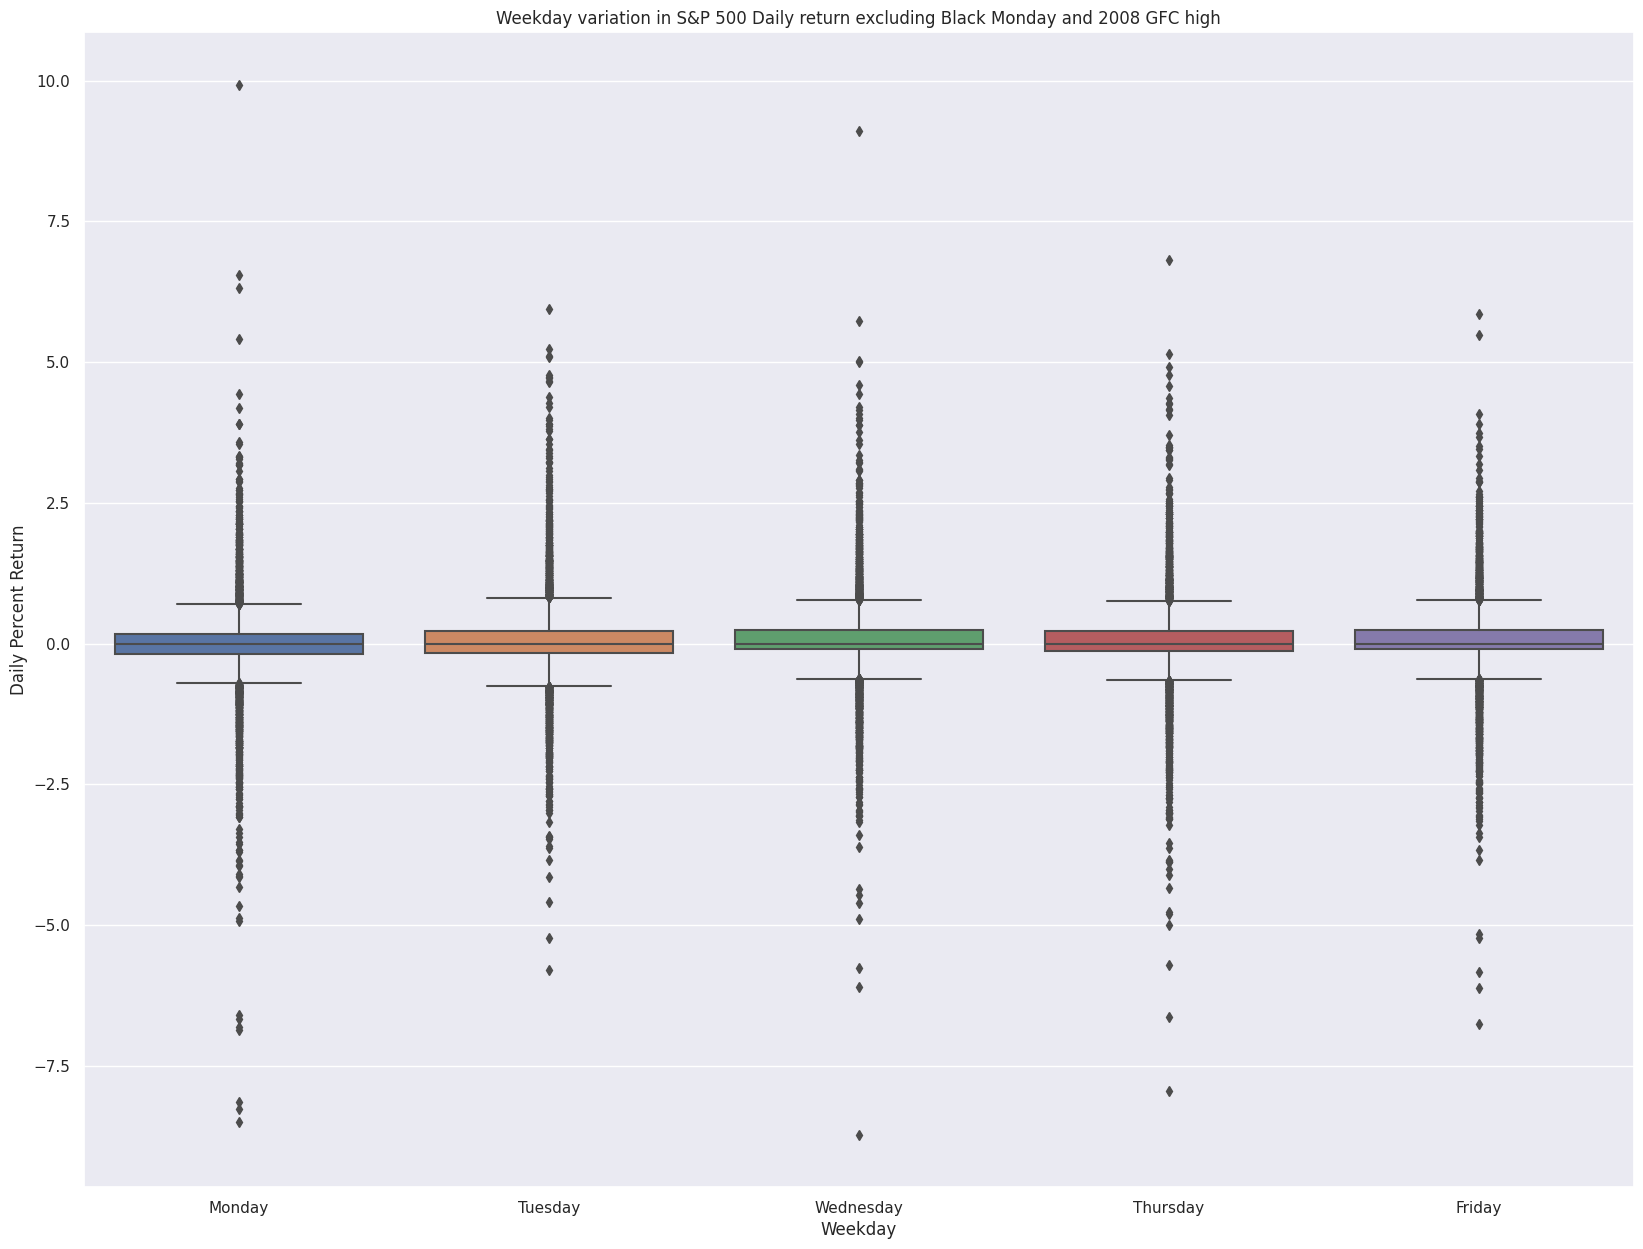

In [ ]:
#Display box plot for each month showing percent changes per day
index_dy = ['Monday','Tuesday','Wednesday','Thursday','Friday'] # Reorder index
sns.set(rc = {'figure.figsize':(20,15)}) #Set figure size
sns.boxplot(x='D_nm',y='P_day', data =data2, order = index_dy)

plt.title("Weekday variation in S&P 500 Daily return excluding Black Monday and 2008 GFC high")
plt.xlabel("Weekday")
plt.ylabel("Daily Percent Return")